## Training the Single Atom Diffusion Scaling Law in Python

Author: Yifan Wang [(wangyf@udel.edu)](wangyf@udel.edu)

The scaling law correlates the diffusion activation energy for support single atoms on the support with physcial descriptors

The form of the scaling law is obtained from various supervised machine learning (ML) methods and the traing procedure is shown below. The ML methods used include:

- [LASSO regression](#LASSO) 

- [Ridge regression](#ridge)

- [Elastic net](#enet)

- [Ordinary Least Square (OLS) regression](#OLS)

- [Genetic Programming (GP) based on sybomlic regression](#enet)



The primary physical descriptors (features) include 

- $ E_c $ (cohesive energy of the metal)  

- $ E_{bind} $ (the binding energy of the single atom)

The secondary descriptors are the polynomial terms (orders from -2 to 2) of the primary descriptors  

After simpliying the descriptor space, we discovered [the diffusion scaling law (DSL)](#DSL) based on the most significant descriptor $ (E_{bind})^2/E_c $:

__DSL__ - $ E_a \propto (E_{bind})^2/E_c $ 

The performance of DSL is compared with other ML [models](#models) and across [supports](#supports) and [metals](#metals)


In [1]:
#%% Import all necessary libraries 

import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
 

from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import (ElasticNet, ElasticNetCV, Lasso, LassoCV,
                                  Ridge, RidgeCV, enet_path, lasso_path)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (LeaveOneOut, RepeatedKFold,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# import customized plotting functions
import regression_tools as rtools

# Set plotting format
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['ytick.major.width'] = 3
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['figure.dpi'] = 300. # set plotting resolution



### Step 1 - Import Data 

In [2]:
#%% Import adsorption data from a csv file

data = pd.read_csv('Ea_data.csv', header = 0)

metal = np.array(data['metal'])
support = np.array(data['support'])
Ec = np.array(data['Ec']) # cohesive energy of the metal
Ebind = np.array(data['Ebind']) #binding energy of the single atom
Ea = np.array(data['Ea']) # Diffusion barrier of the single atom onto the support

### Step 2 - Generate the descriptors (features)

In [3]:
#%% Prepare for the descriptors (features) 

# Numerical orders
orders = [1, -1, 0.5, -0.5, 2, -2]


def transformers(xv, orders):

    '''
    Transform each column of primary featurs into secondary features
    '''
    x_features = np.reshape(xv, (len(xv),1))
    
    for oi in orders[1:]:
        x_features = np.concatenate((x_features, np.reshape(xv, (len(xv),1))**oi), axis = 1)
    
    '''
    Add additional features
    '''
    x_features = np.concatenate((x_features, np.log(np.reshape(xv, (len(xv),1)))), axis = 1)
    
    return x_features
'''
Get the names and orders
'''    
# primary and secondary feature names
x_primary_feature_names = ['Ec', 'Ebind']
x_secondary_feature_names_2d = []
orders_log = orders + ['ln']

# The number for all numerical opeators 
all_orders_log = []

for xi in x_primary_feature_names:  
    x_secondary_feature_names_2d.append([xi + '_' + str(oi) for oi in orders_log])
    all_orders_log += orders_log
    
x_secondary_feature_names = []
for xi in x_secondary_feature_names_2d:
    x_secondary_feature_names += xi


'''
Transform the primary features to the secondary features
''' 
Ec_features = transformers(Ec, orders)    
Ebind_features = transformers(Ebind, orders)   

# Combine two sets of features
X_init = np.concatenate((Ec_features, Ebind_features),axis = 1) 

poly = PolynomialFeatures(2, interaction_only=True)
X_poly = poly.fit_transform(X_init)
orders_m = poly.powers_

'''
Select nonzero features
'''
x_features_poly = ['1'] # nonzero feature names in a 2d list
poly_indices_nonrepeat = [0] # indices in the polynominal order matrix 
# Create feature names for plotting in Latex
x_plot_feature_names = ['b'] + x_secondary_feature_names
x_plot_feature_names = ['1', r'$\rm E_c$', r'$\rm E_c^{-1}$', r'$\rm E_c^{0.5}$', r'$\rm E_c^{-0.5}$',  r'$\rm E_c^2$', r'$\rm E_c^{-2}$', r'$\rm ln(E_c)$', r'$\rm E_{bind}$', r'$\rm E_{bind}^{-1}$', r'$\rm E_{bind}^{0.5}$', r'$\rm E_{bind}^{-0.5}$', r'$\rm E_{bind}^2$', r'$\rm E_{bind}^{-2}$', r'$\rm ln(E_{bind})$']

n_features = len(x_plot_feature_names)


'''
Get the indices and feature names for nonzero features, 
namely with nonzero order
'''
for pi, powers in enumerate(poly.powers_):
    
    powers_nonzero = (powers > 0).nonzero()[0]
    
    if not list(powers_nonzero) == []:
        
        features_nonzero = [x_secondary_feature_names[pi] for pi in powers_nonzero]
        orders_nonzero = np.array([all_orders_log[pi] for pi in powers_nonzero])
    
        try: 
            # making sure the zero sum is from one feature each
            ordersum = orders_nonzero.sum()
            f1_order = powers_nonzero[0] in range(0, len(x_secondary_feature_names_2d[0]))
            f2_order = powers_nonzero[1] in range(len(x_secondary_feature_names_2d[0]), len(x_secondary_feature_names_2d[0])+len(x_secondary_feature_names_2d[1]))
        
            if ordersum == 0:
                if (f1_order and f2_order):
                    x_features_poly.append(features_nonzero)
                    poly_indices_nonrepeat.append(pi)
       
            else:
                    x_features_poly.append(features_nonzero)
                    poly_indices_nonrepeat.append(pi)
       
        except:
            
            x_features_poly.append(features_nonzero)
            poly_indices_nonrepeat.append(pi)

poly_indices_nonrepeat = np.array(poly_indices_nonrepeat)


x_features_poly_combined = []
for fi in x_features_poly:
    if len(fi) > 1:
        fi_combined = []
        for fj in fi:
            fi_combined += fj
            fi_combined = ''.join(fi_combined)

        x_features_poly_combined.append(fi_combined)
    else: x_features_poly_combined.append(fi[0])


'''
Additional Screening, take out repeated features (this is done manually)
'''
repeated_indices = [16, 18, 27, 29, 40, 49, 83, 85, 87, 89, 93, 95]
poly_indices_nonrepeat = [poly_indices_nonrepeat[i] for i in range(0, len(poly_indices_nonrepeat)) if i not in repeated_indices]
x_features_poly_combined = [x_features_poly_combined[i] for i in range(0, len(x_features_poly_combined)) if i not in repeated_indices]
x_features_poly = [x_features_poly[i] for i in range(0, len(x_features_poly)) if i not in repeated_indices]



### Step 3 - Scaling the features to zero mean and unit variance


In [4]:
#%%Process X and y, scale

X_before_scaling = X_poly[:,poly_indices_nonrepeat]
y = Ea
scaler = StandardScaler().fit(X_before_scaling[:,1:])

sv = scaler.scale_
mv = scaler.mean_

X = X_before_scaling.copy()
X[:,1:] = scaler.transform(X_before_scaling[:,1:])
fit_int_flag = False # Not fitting for intercept, as the first coefficient is the intercept


### Step 4 - Set the cross-validation scheme


In [5]:
#%% Cross validation setting

# Set random state here
random_state = 0
# Train test split, save 20% of data point to the test set
X_train, X_test, y_train, y_test, X_before_train, X_before_test = train_test_split(X, y, X_before_scaling, test_size=0.2, random_state = random_state)
                    
                    
# The alpha grid used for plotting path
alphas_grid = np.logspace(0, -3, 20)

# Cross-validation scheme                                  
rkf = RepeatedKFold(n_splits = 10, n_repeats = 10 , random_state =random_state)

# Explicitly take out the train/test set
X_cv_train, y_cv_train, X_cv_test, y_cv_test = [],[],[],[]

for train_index, test_index in rkf.split(X_train):
    X_cv_train.append(X_train[train_index])
    y_cv_train.append(y_train[train_index])
    X_cv_test.append(X_train[test_index])
    y_cv_test.append(y_train[test_index])
    

### Step 5 - Train ML models

#### LASSO Regression<a name="lasso"></a>


No handles with labels found to put in legend.


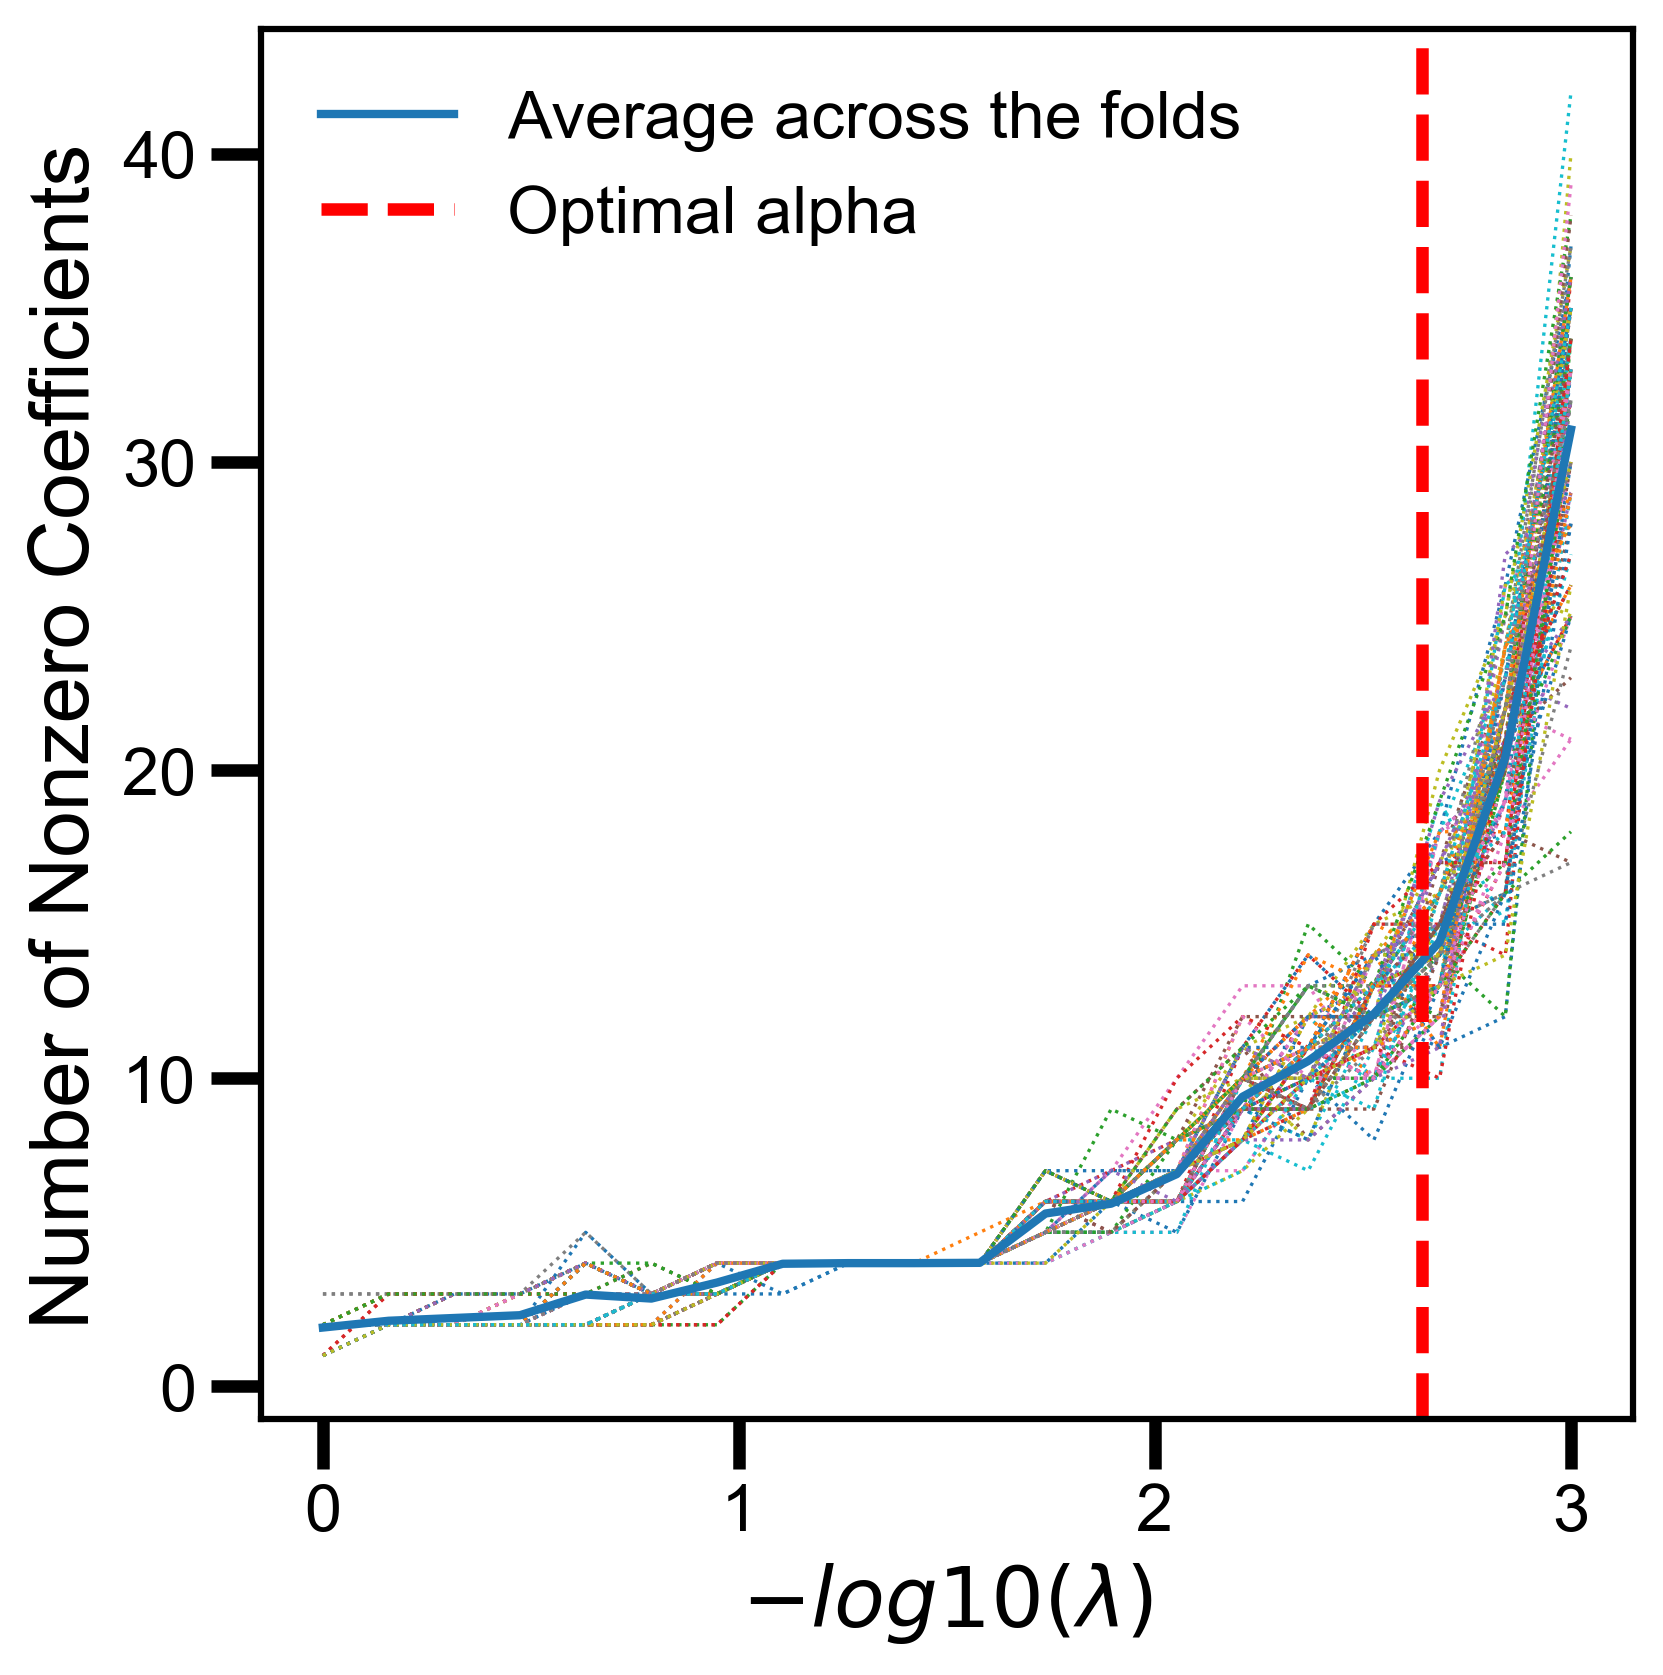

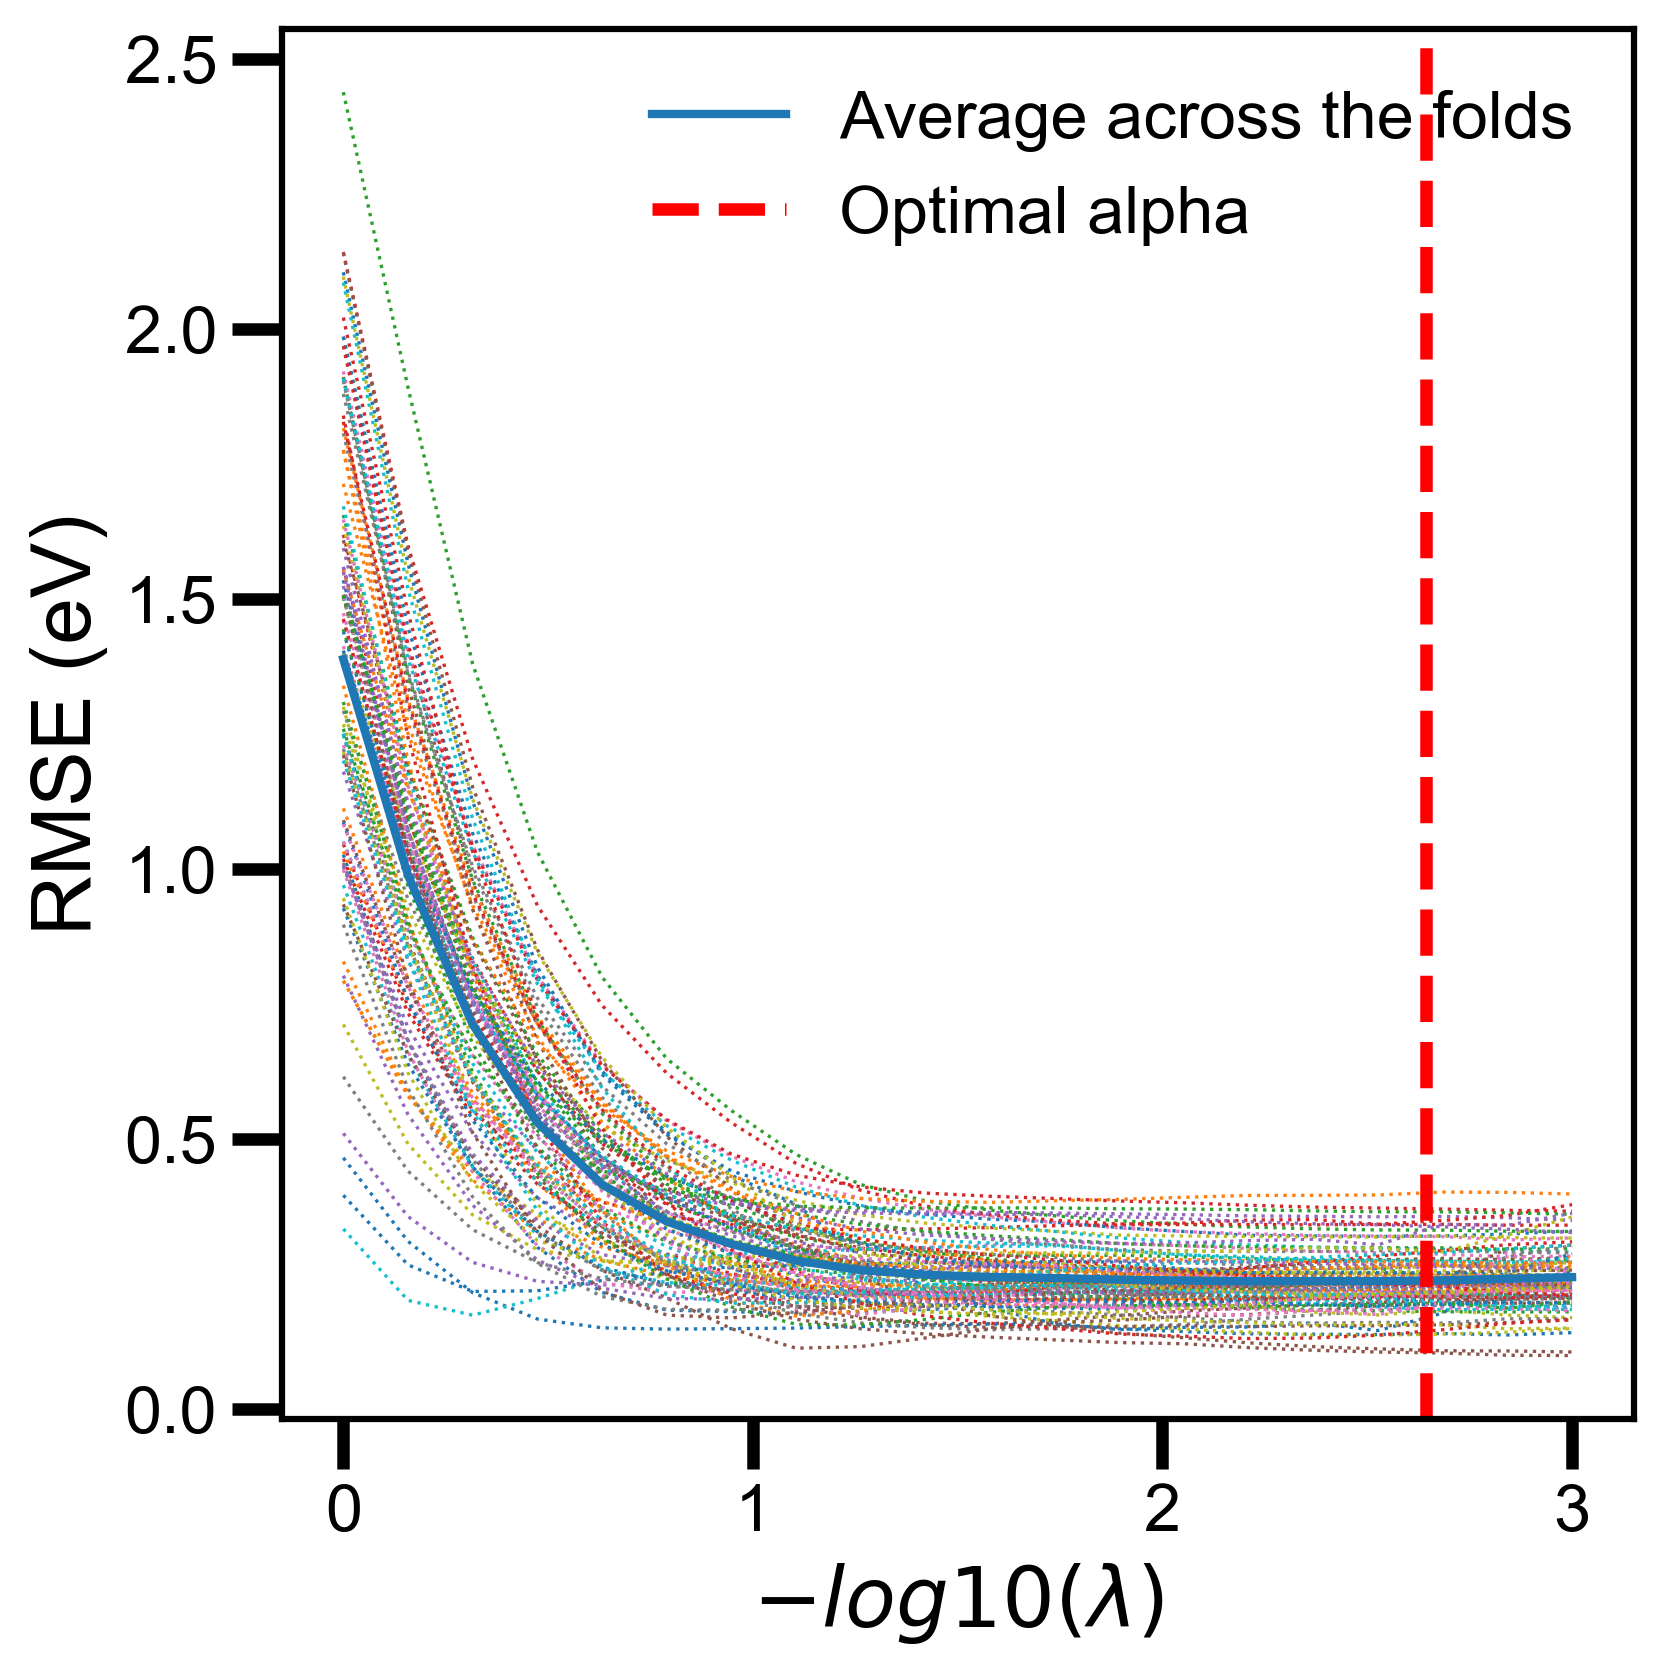

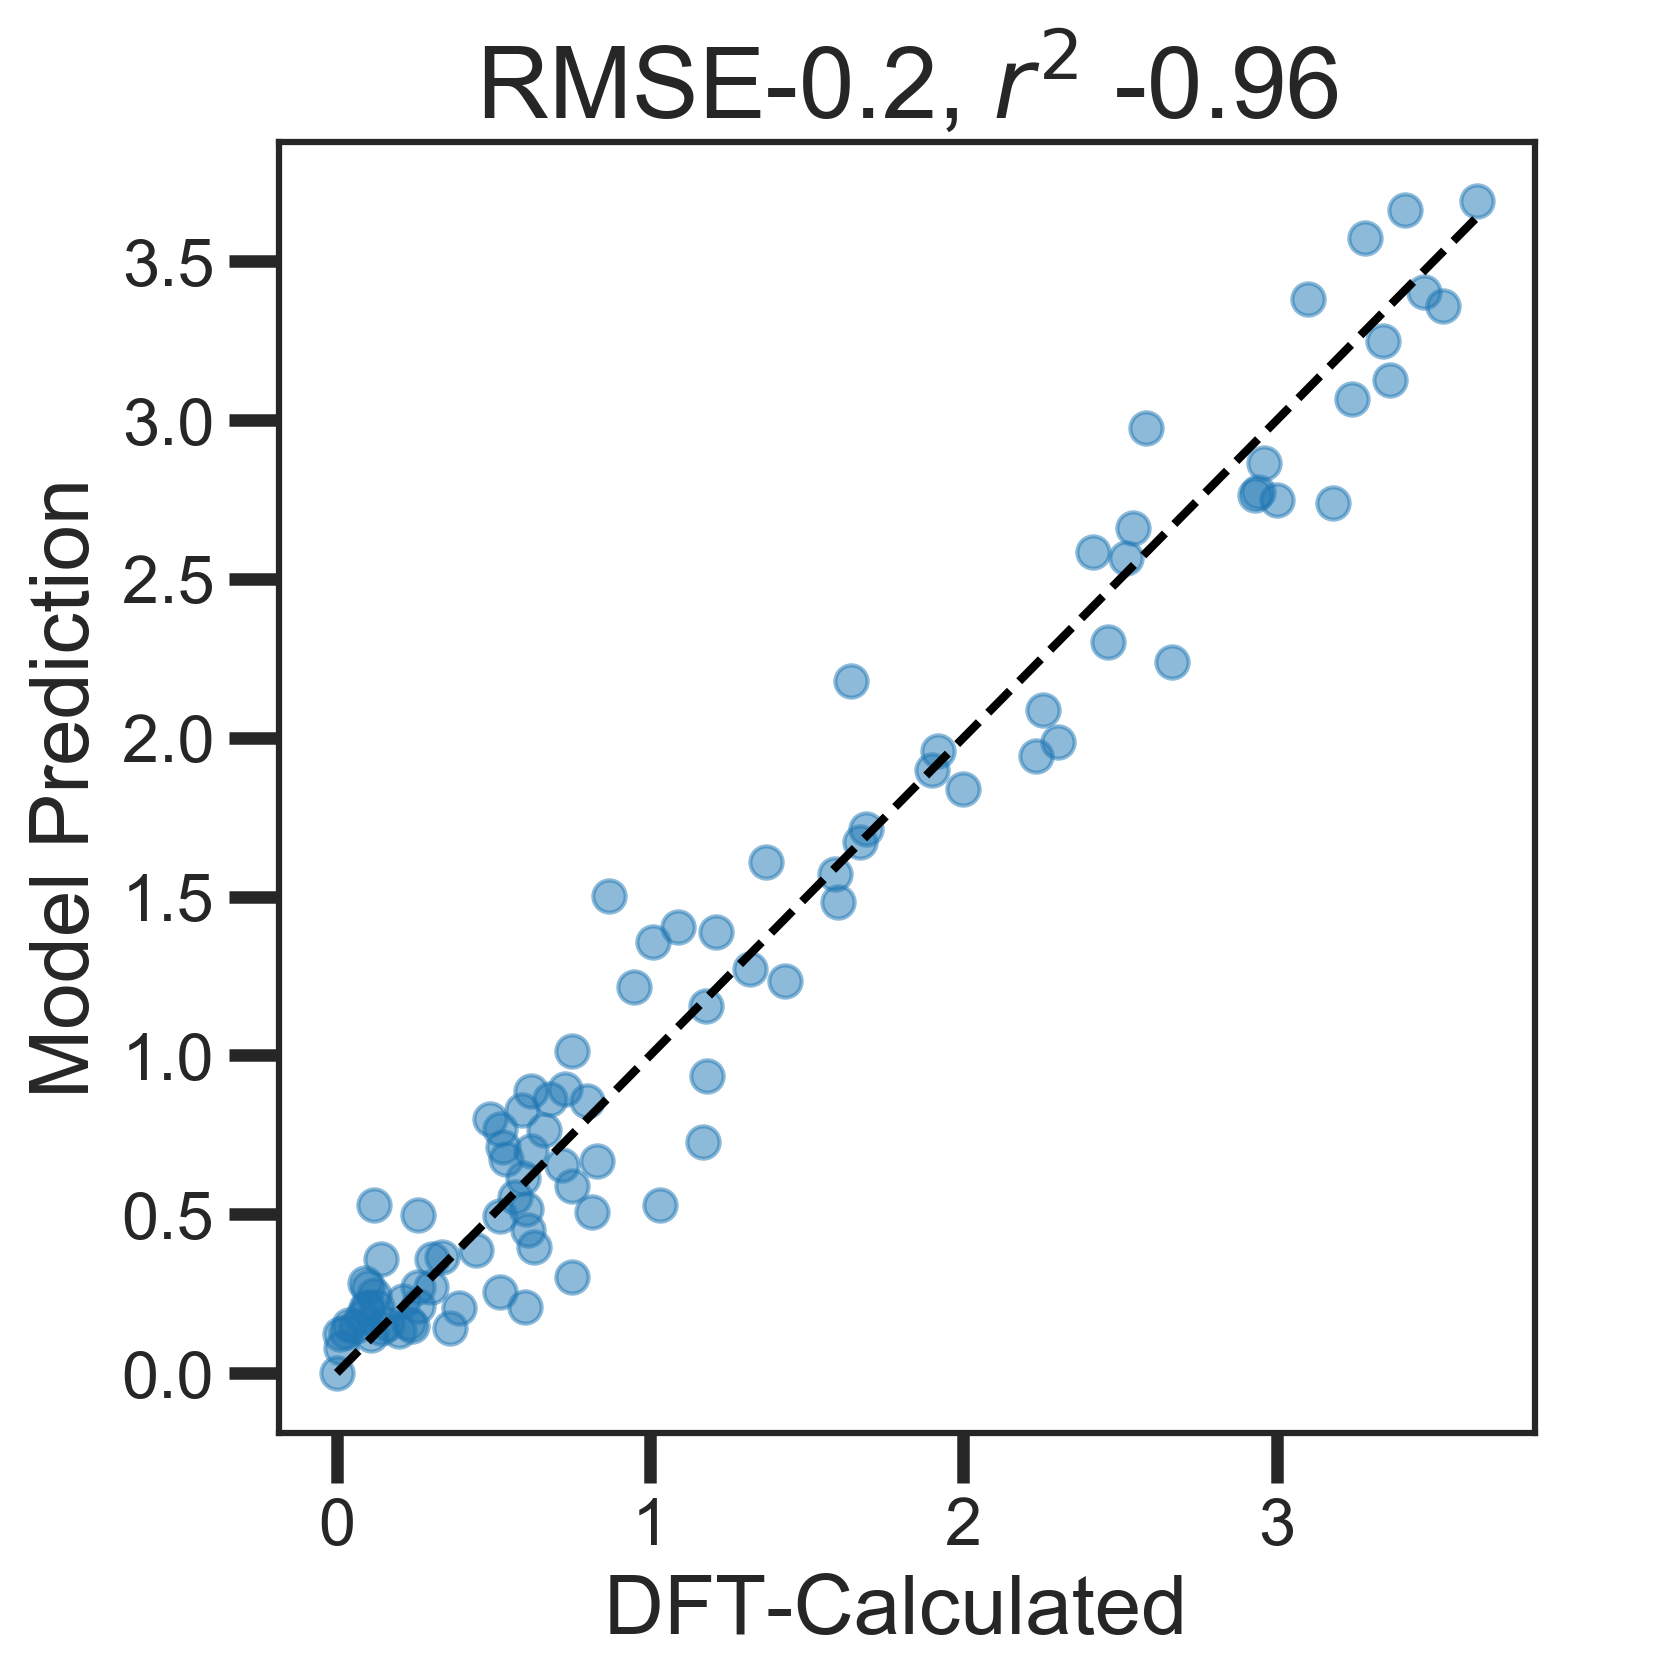

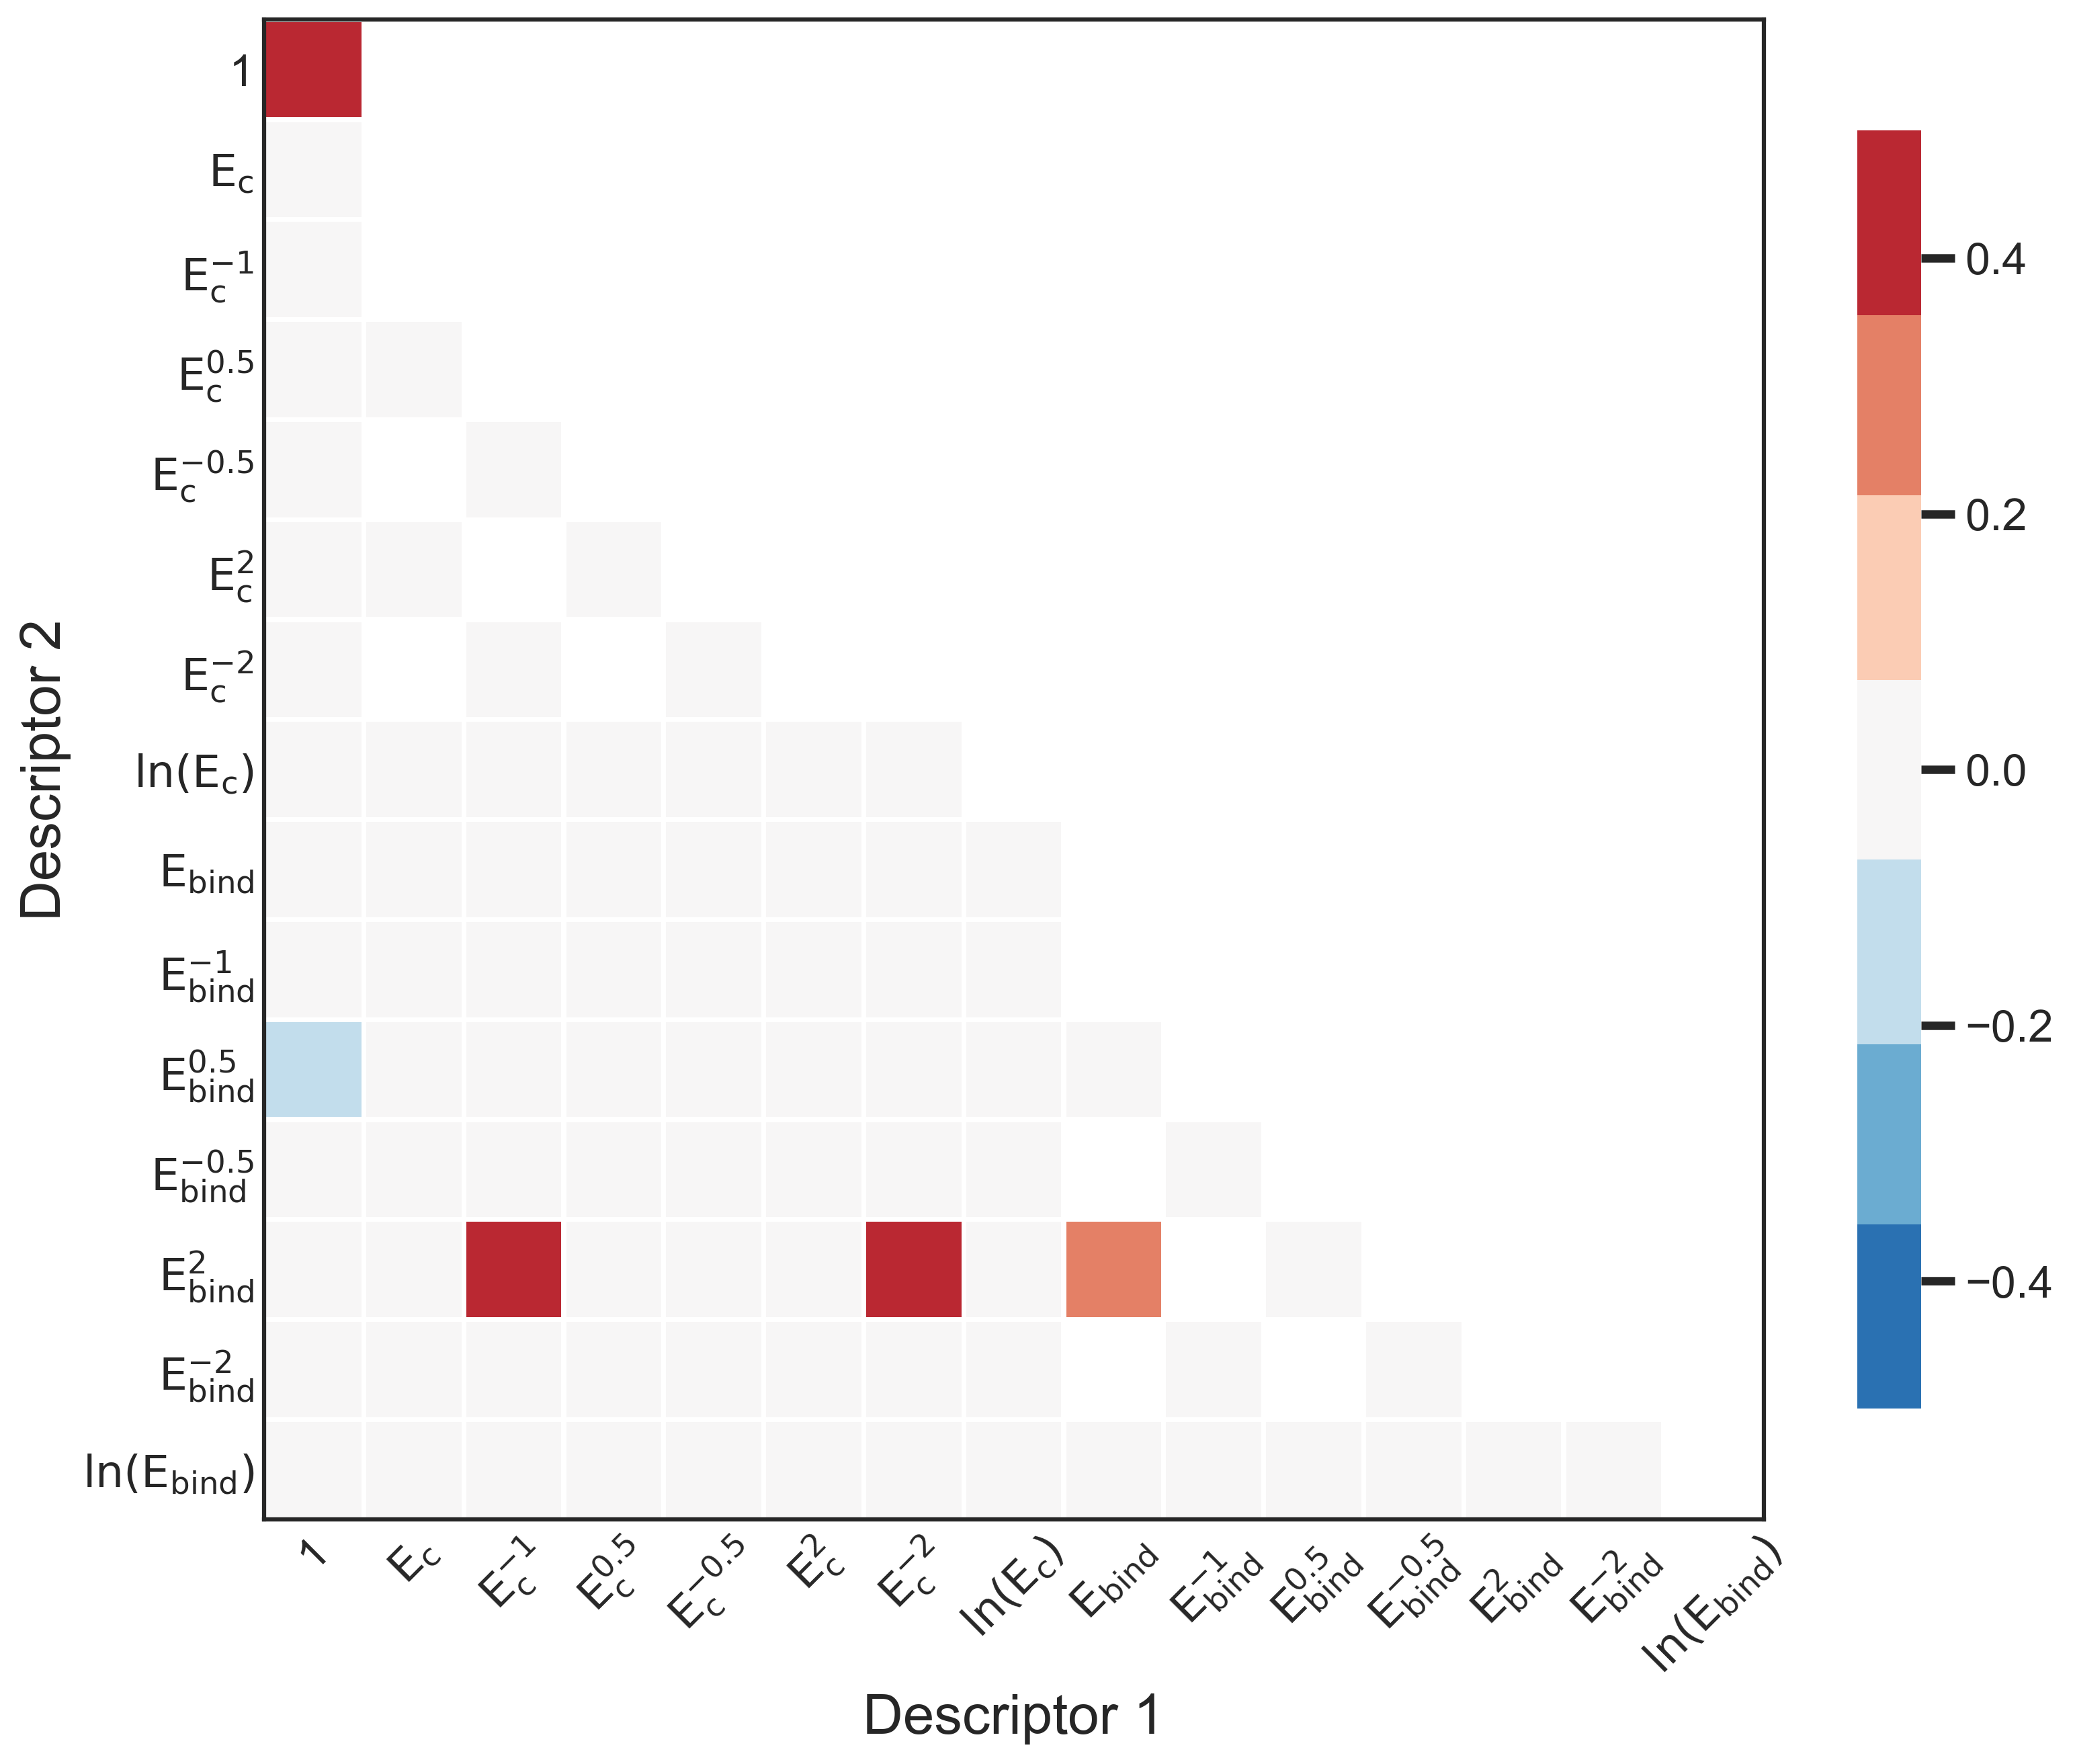

In [6]:
#%% LASSO regression
'''   
# LassoCV to obtain the best alpha, the proper training of Lasso
'''
model_name = 'lasso'
base_dir = os.getcwd()
output_dir = os.path.join(base_dir, model_name)
if not os.path.exists(output_dir): os.makedirs(output_dir)    

lasso_cv  = LassoCV(cv = rkf,  max_iter = 1e7, tol = 0.001, fit_intercept=fit_int_flag, random_state=random_state)
lasso_cv.fit(X_train, y_train)

# the optimal alpha from lassocv
lasso_alpha = lasso_cv.alpha_
# Coefficients for each term
lasso_coefs = lasso_cv.coef_
# The original intercepts 
lasso_intercept = lasso_cv.intercept_

# Access the errors 
y_predict_test = lasso_cv.predict(X_test)
y_predict_train = lasso_cv.predict(X_train)


lasso_RMSE_test = np.sqrt(mean_squared_error(y_test, y_predict_test))
lasso_RMSE_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
lasso_r2_train = r2_score(y_train, y_predict_train)

# Use alpha grid prepare for lassopath
lasso_RMSE_path, lasso_coef_path = rtools.cal_path(alphas_grid, Lasso, X_cv_train, y_cv_train, X_cv_test, y_cv_test, fit_int_flag)
rtools.plot_path(X, y, lasso_alpha, alphas_grid, lasso_RMSE_path, lasso_coef_path, lasso_cv, model_name, output_dir)
# Plot the parity plot 
lasso_RMSE, lasso_r2 = rtools.parity_plot(y, lasso_cv.predict(X), model_name, output_dir, lasso_RMSE_test)
lasso_prediction = lasso_cv.predict(X)

# The indices for non-zero coefficients/significant cluster interactions 
J_index = np.nonzero(lasso_coefs)[0]
# The number of non-zero coefficients/significant cluster interactions  
n_nonzero = len(J_index)
# The values of non-zero coefficients/significant cluster interactions  
J_nonzero = lasso_coefs[J_index] 

# collect nonzero freature names
x_feature_nonzero_combined = [x_features_poly_combined[pi] for pi in J_index]
x_feature_nonzero = [x_features_poly[pi] for pi in J_index]

'''
Convert the coefficient to unnormalized form
'''
lasso_coefs_unnormailized = np.zeros_like(lasso_coefs)
lasso_coefs_unnormailized[1:] = lasso_coefs[1:]/sv
lasso_coefs_unnormailized[0] = lasso_coefs[0] - np.sum(mv/sv*lasso_coefs[1:])

# Plot coefficients matrix
lasso_coef_matrix = rtools.make_coef_matrix(x_feature_nonzero, J_nonzero, n_features, x_secondary_feature_names)
rtools.plot_tri_correlation_matrix(lasso_coef_matrix, output_dir, x_plot_feature_names, model_name)


#### Ridge regression<a name="ridge"></a>


C:\Users\yifan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
No handles with labels found to put in legend.


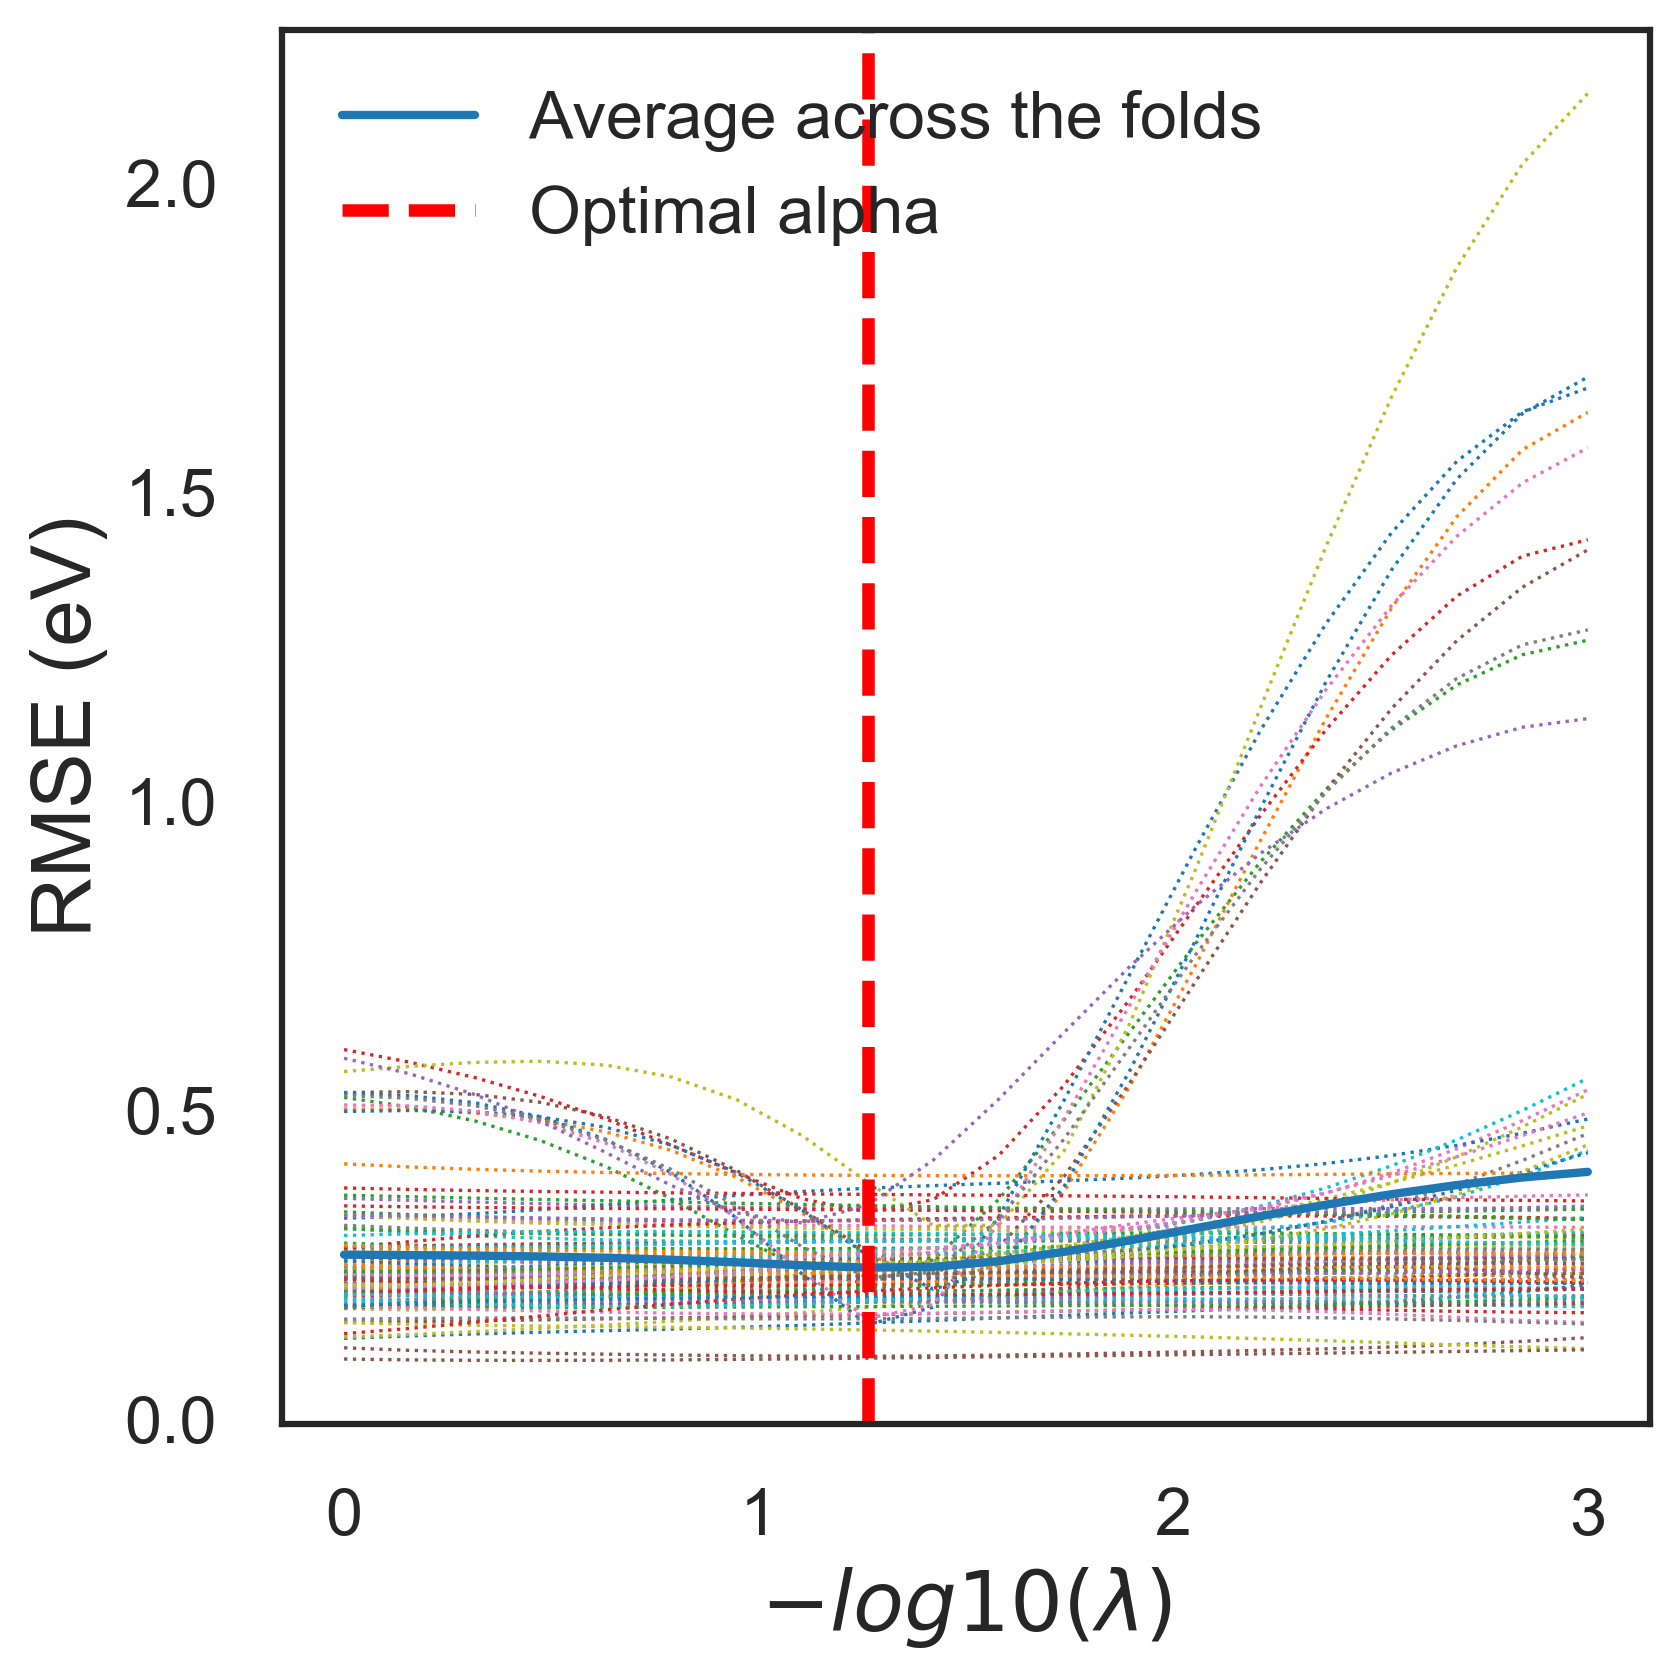

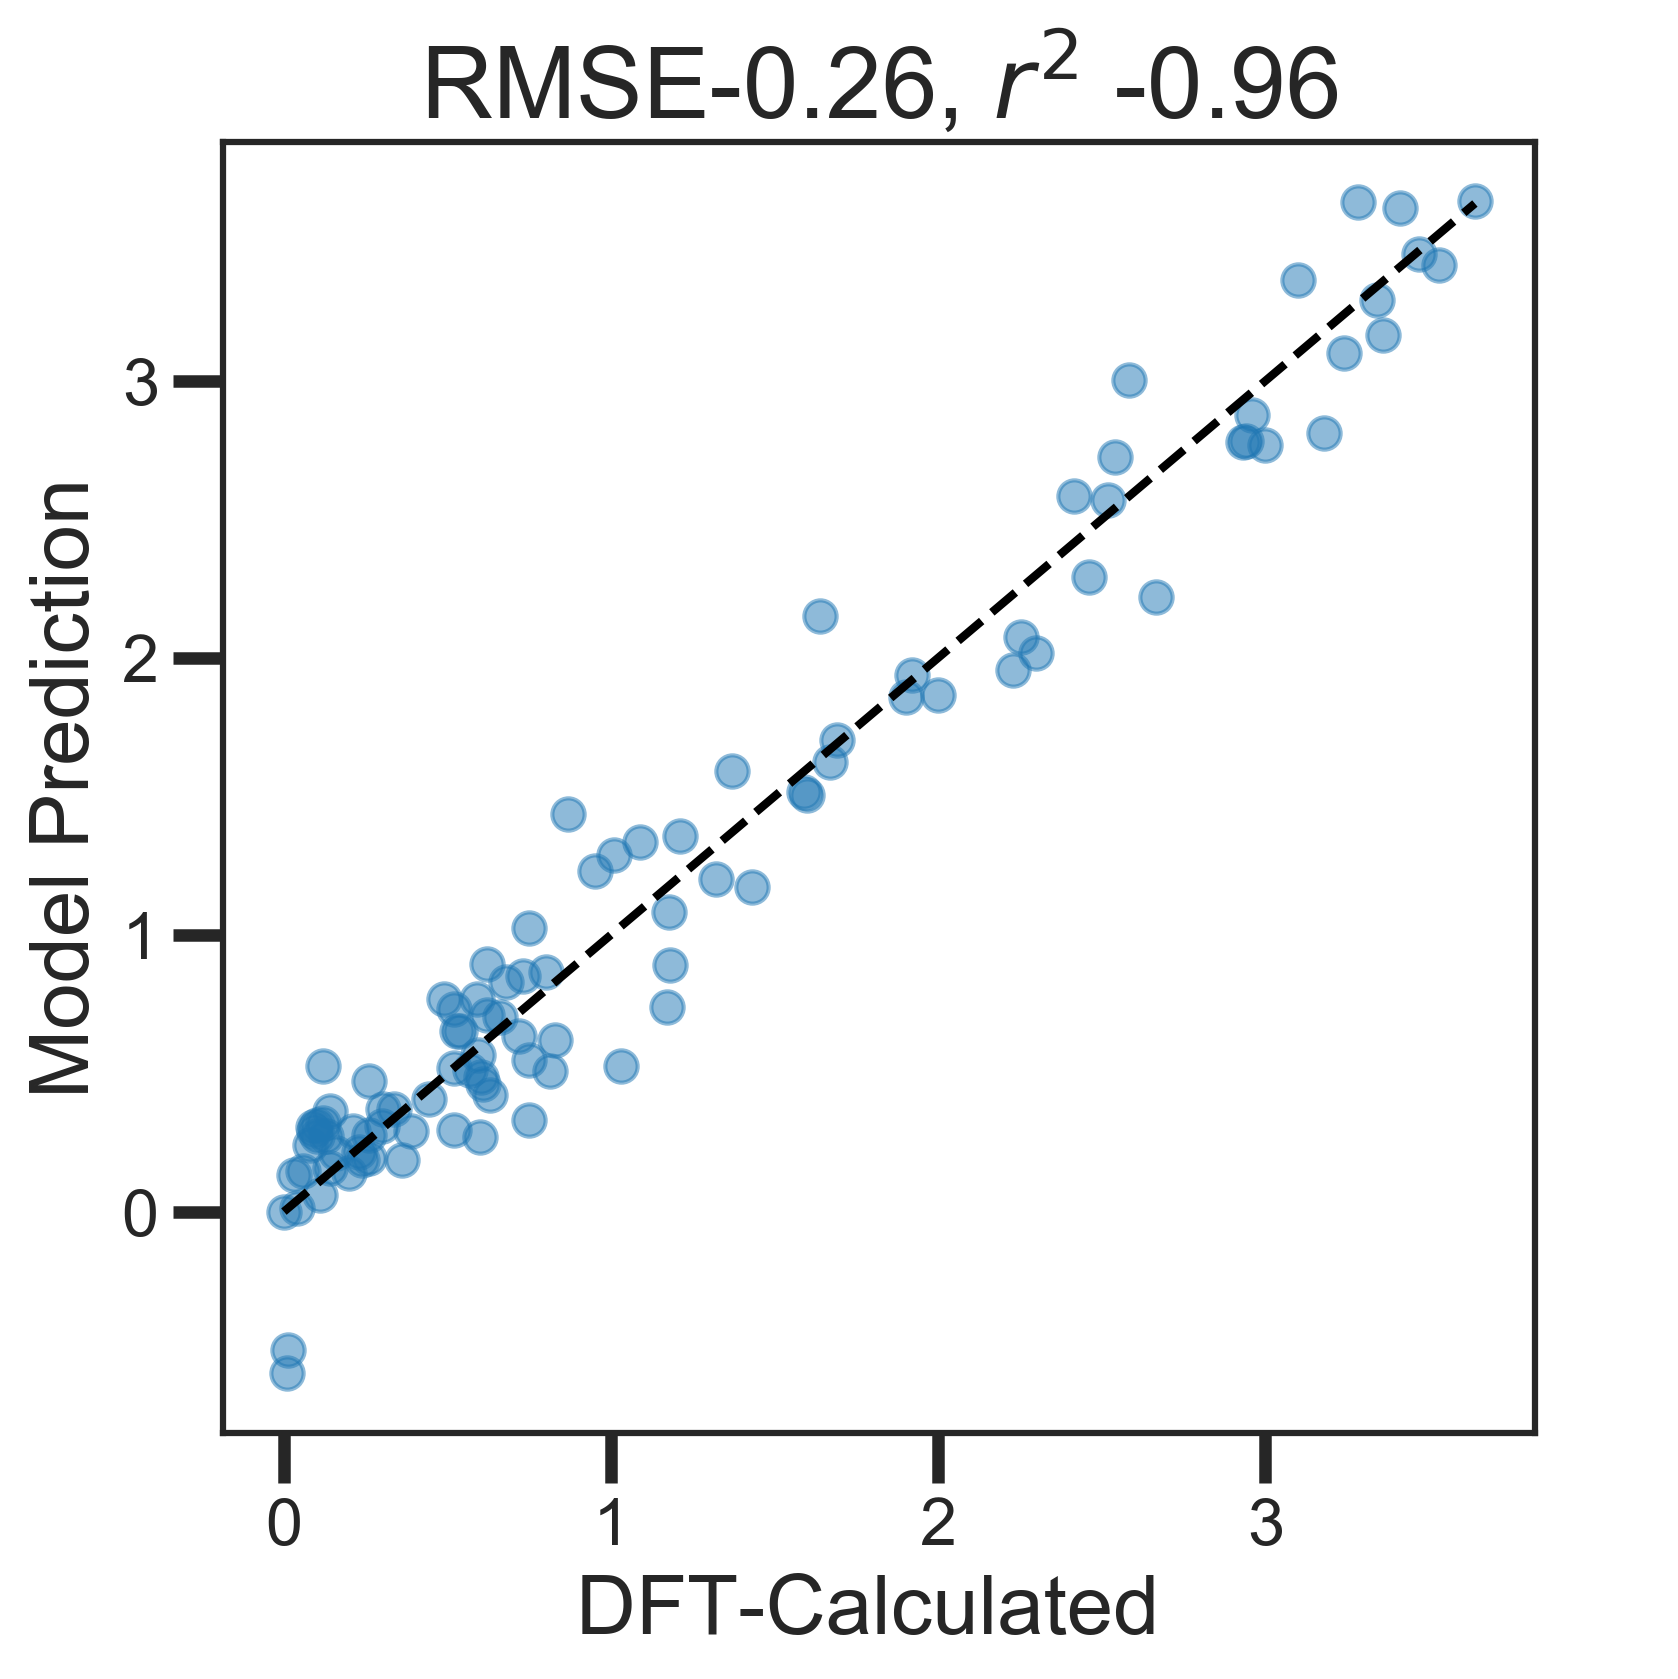

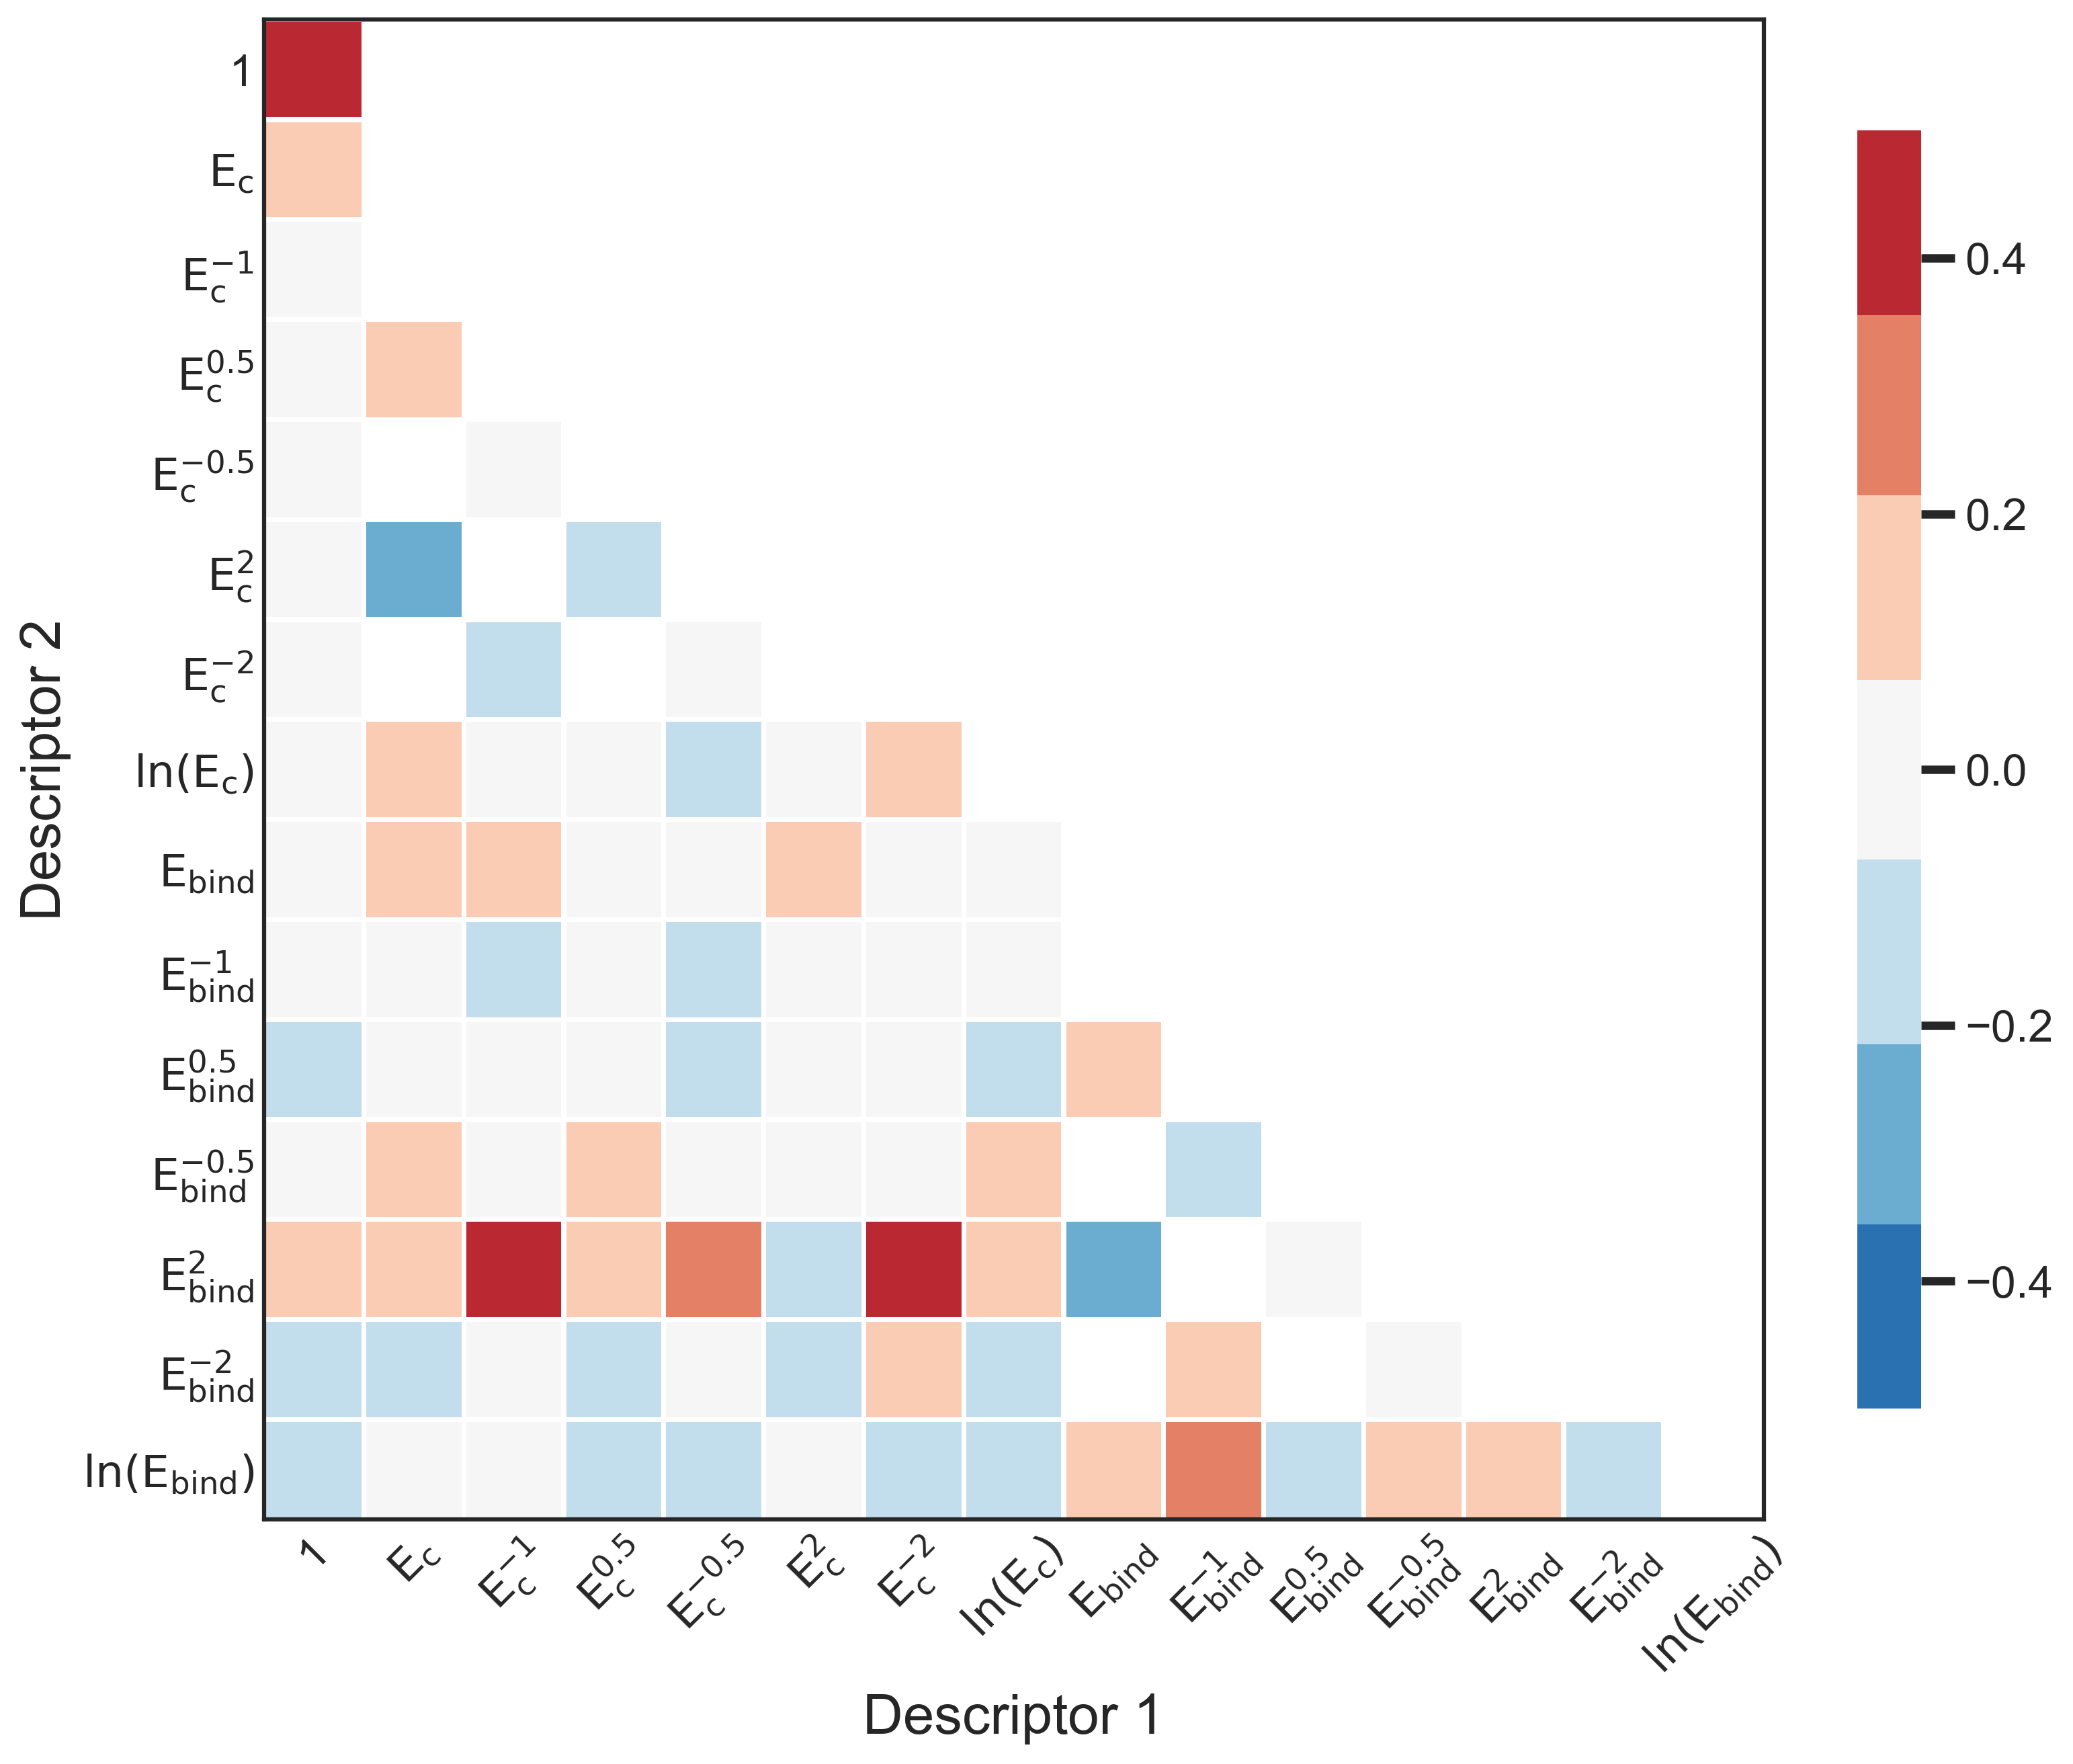

In [7]:
#%% Ridge regression

'''
# RidgeCV to obtain the best alpha, the proper training of ridge
'''

model_name = 'ridge'
output_dir = os.path.join(base_dir, model_name)
if not os.path.exists(output_dir): os.makedirs(output_dir)    

alphas_grid_ridge = np.logspace(0, -3, 20)
ridgeCV = RidgeCV(alphas = alphas_grid_ridge,  cv = rkf, fit_intercept=fit_int_flag)
ridgeCV.fit(X_train, y_train)
ridge_alpha = ridgeCV.alpha_ 
ridge_intercept = ridgeCV.intercept_ 
ridge_coefs = ridgeCV.coef_

# Access the errors 
y_predict_test = ridgeCV.predict(X_test)
y_predict_train = ridgeCV.predict(X_train)

ridge_RMSE_test = np.sqrt(mean_squared_error(y_test, y_predict_test))
ridge_RMSE_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
ridge_r2_train = r2_score(y_train, y_predict_train)   

# plot the rigde path
ridge_RMSE_path, ridge_coef_path = rtools.cal_path(alphas_grid_ridge, Ridge, X_cv_train, y_cv_train, X_cv_test, y_cv_test, fit_int_flag)
rtools.plot_RMSE_path(ridge_alpha, alphas_grid_ridge, ridge_RMSE_path, model_name, output_dir)
# Plot the parity plot 
ridge_RMSE, ridge_r2 = rtools.parity_plot(y, ridgeCV.predict(X), model_name, output_dir, ridge_RMSE_test)

'''
Convert the coefficient to unnormalized form
'''
ridge_coefs_unnormailized = np.zeros_like(ridge_coefs)
ridge_coefs_unnormailized[1:] = ridge_coefs[1:]/sv
ridge_coefs_unnormailized[0] = ridge_coefs[0] - np.sum(mv/sv*lasso_coefs[1:])

# Plot coefficients matrix
ridge_coef_matrix = rtools.make_coef_matrix(x_features_poly, ridge_coefs, n_features, x_secondary_feature_names)
rtools.plot_tri_correlation_matrix(ridge_coef_matrix, output_dir, x_plot_feature_names, model_name)
ridge_prediction = ridgeCV.predict(X)

#### Elastic net<a name="enet"></a>

The L1 ratio is varied and the best model is selected based on testing RMSE

Training Progress: 

4.76 % done
9.52 % done
14.29 % done
19.05 % done
23.81 % done
28.57 % done
33.33 % done
38.10 % done
42.86 % done
47.62 % done
52.38 % done
57.14 % done
61.90 % done
66.67 % done
71.43 % done
76.19 % done
80.95 % done
85.71 % done
90.48 % done
95.24 % done
100.00 % done
No handles with labels found to put in legend.


<Figure size 2400x1800 with 0 Axes>

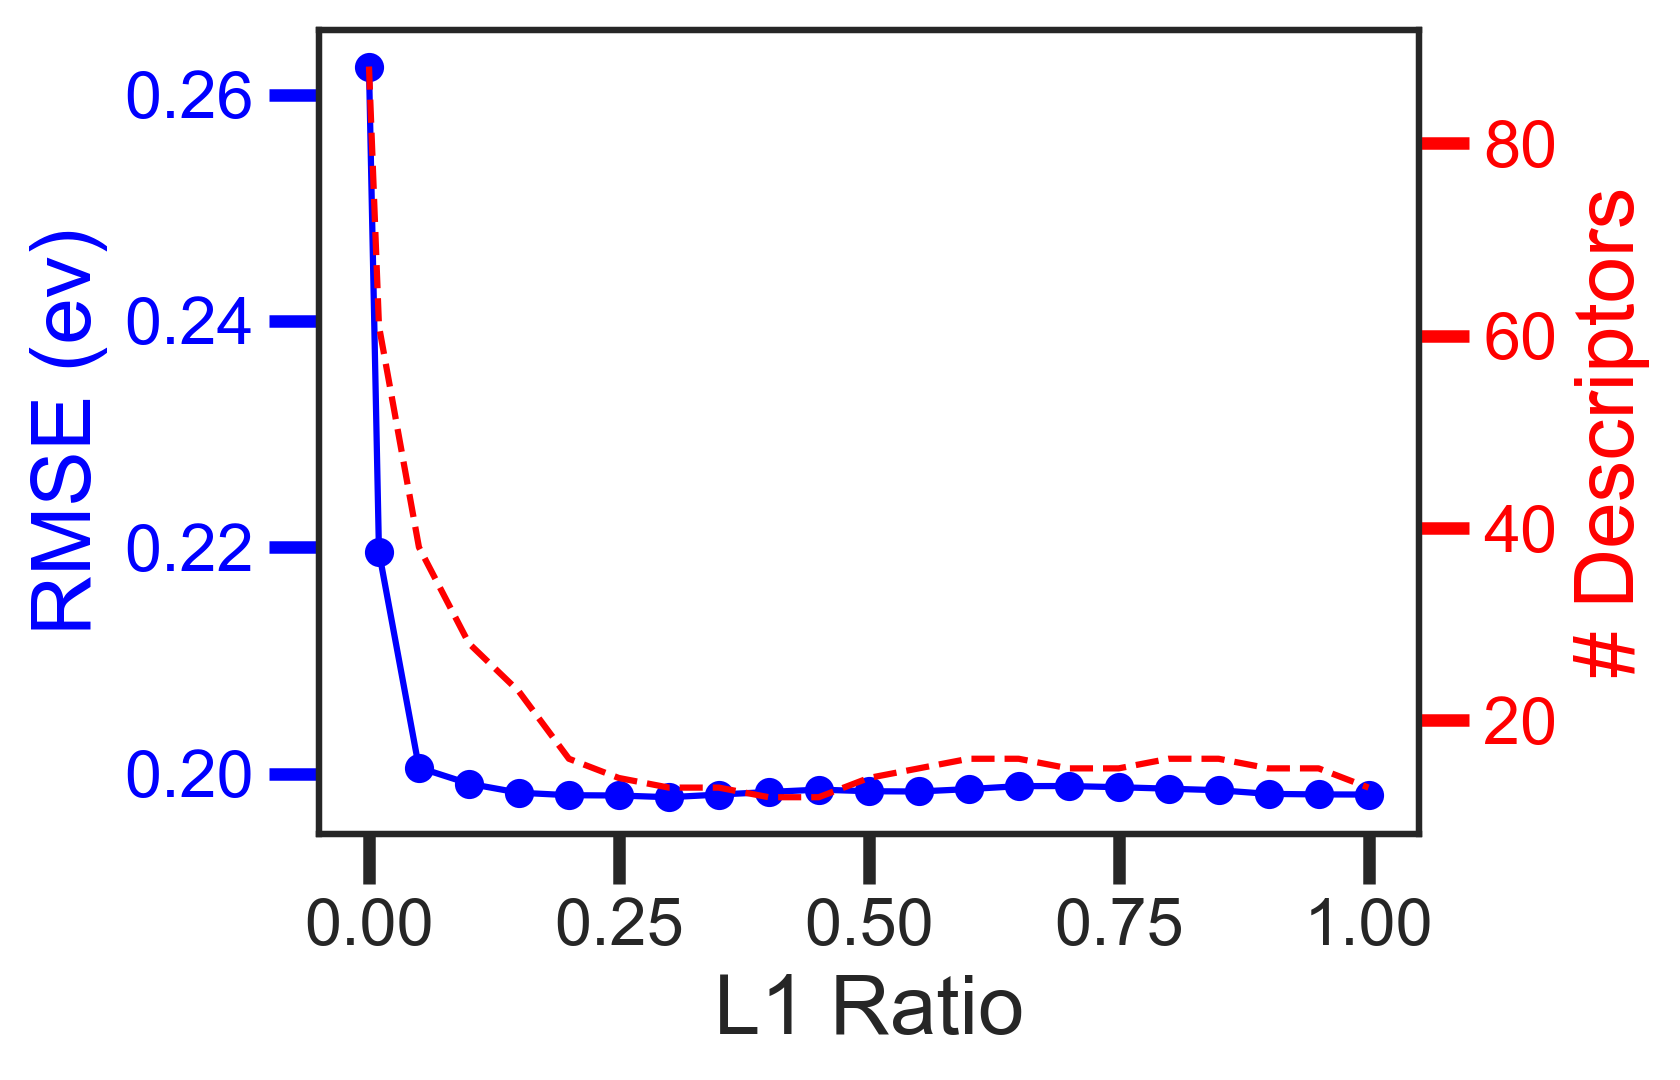

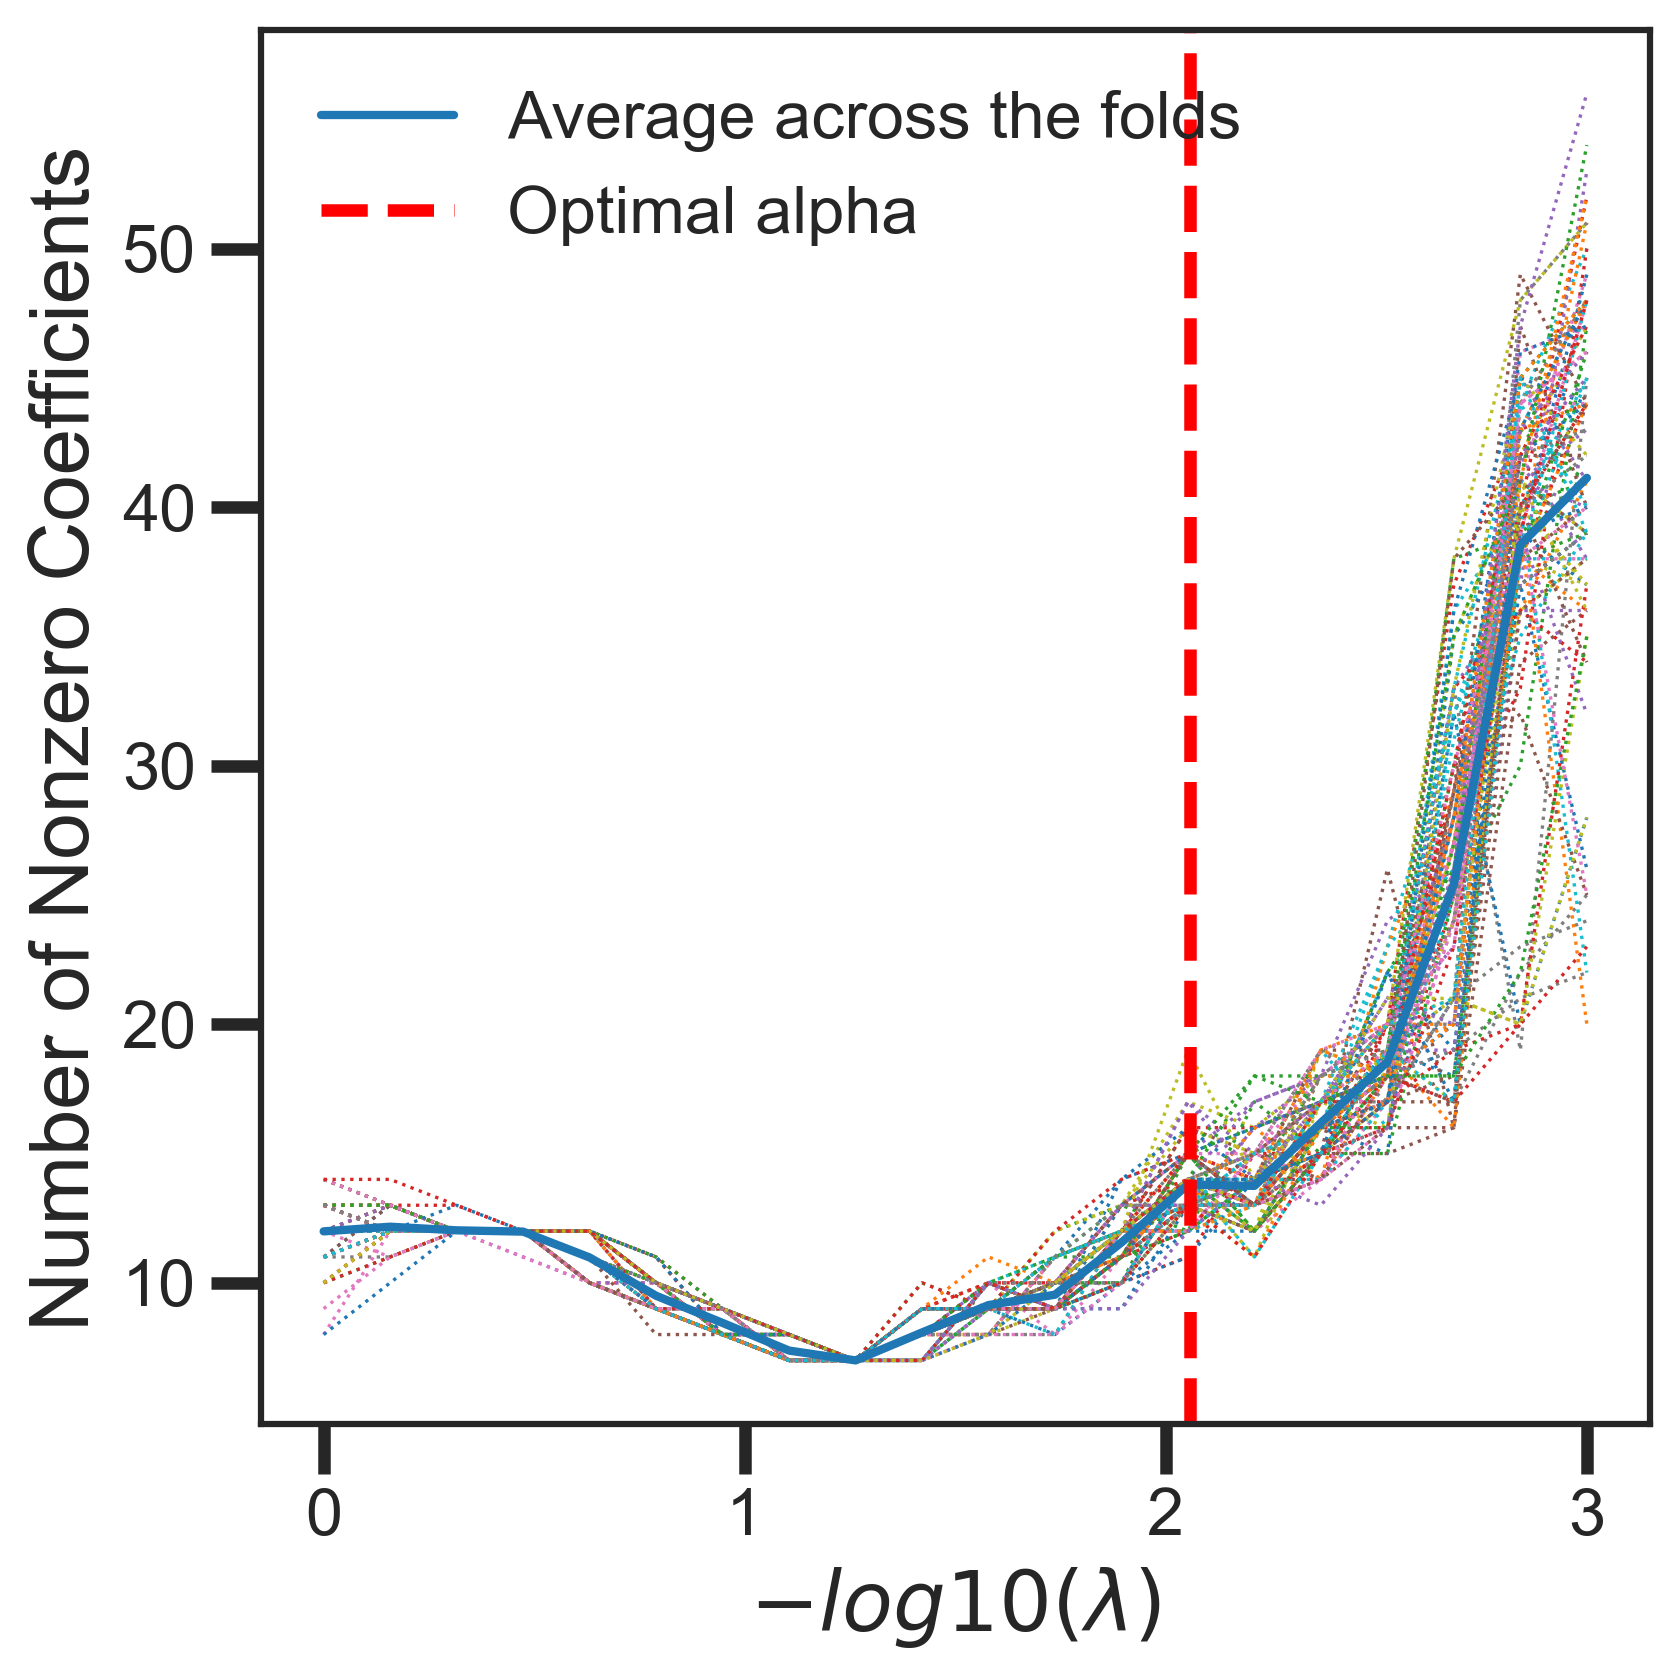

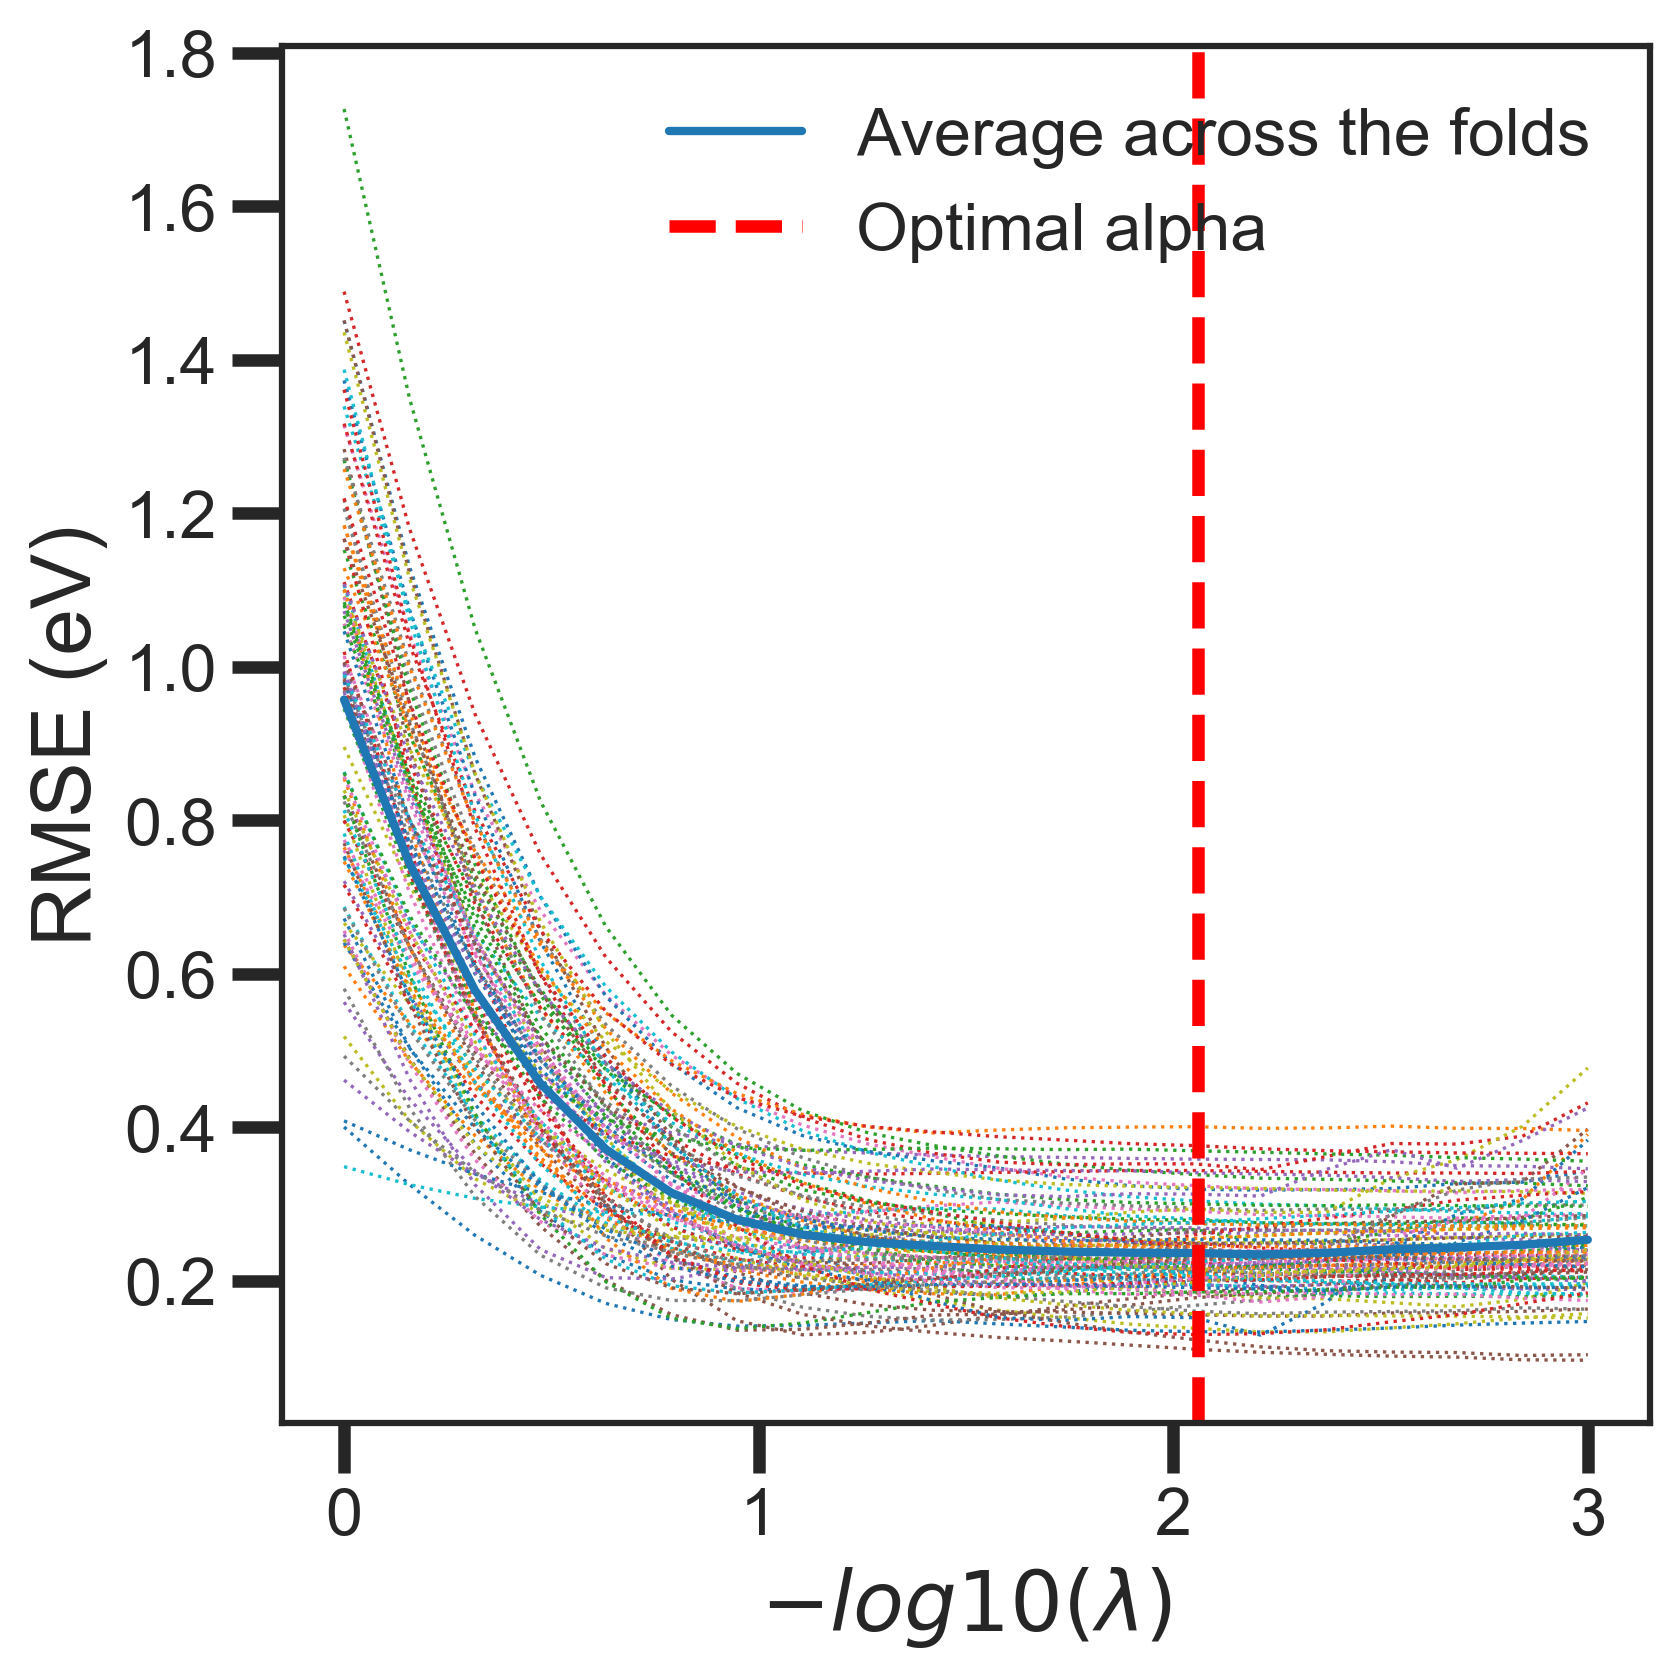

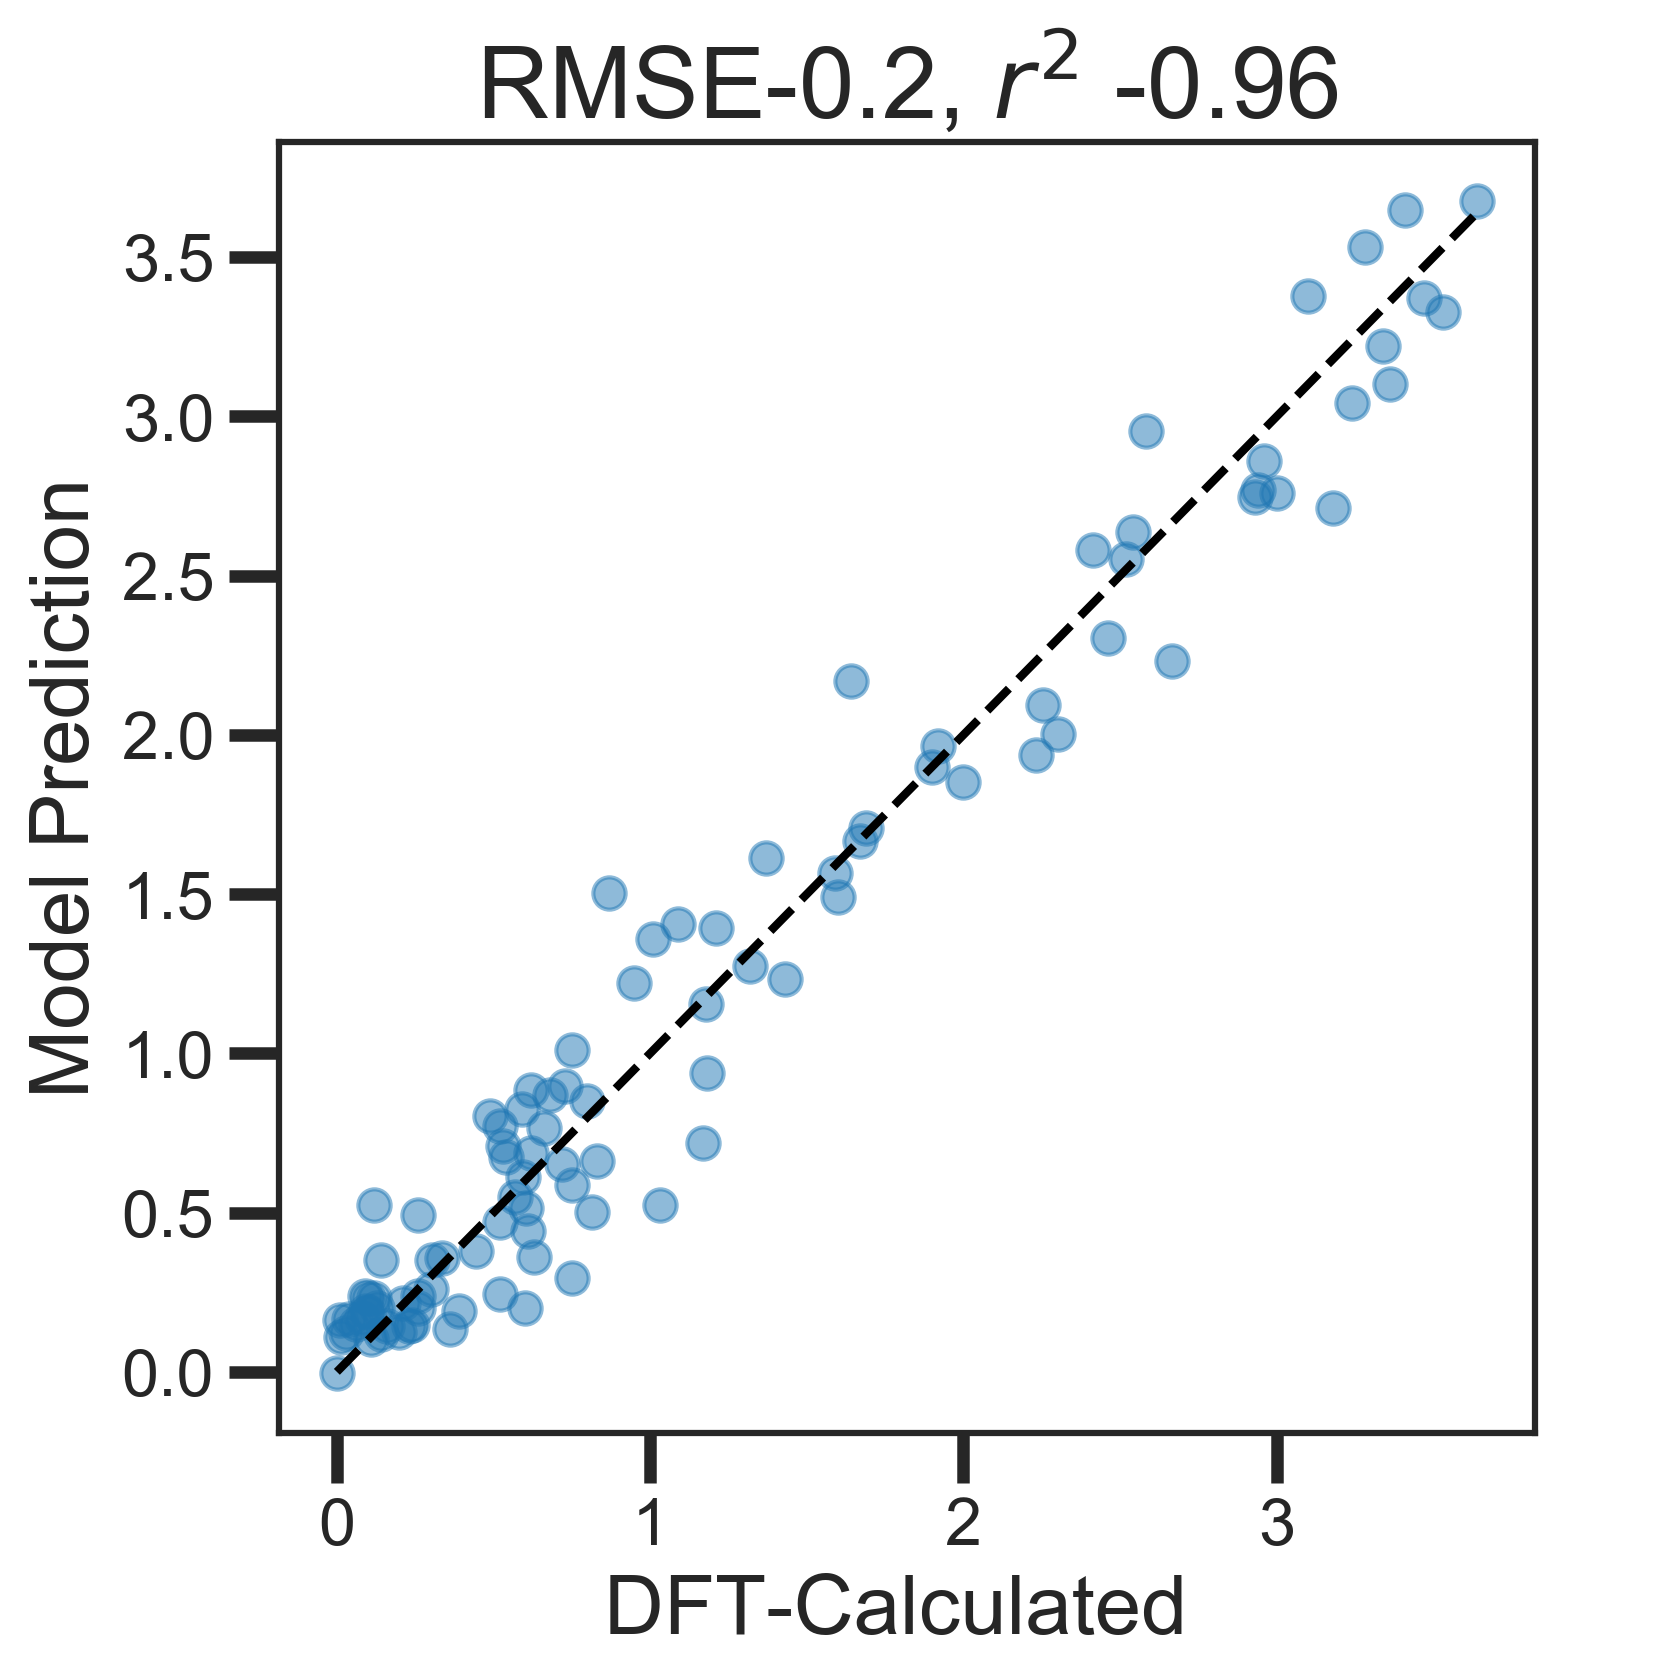

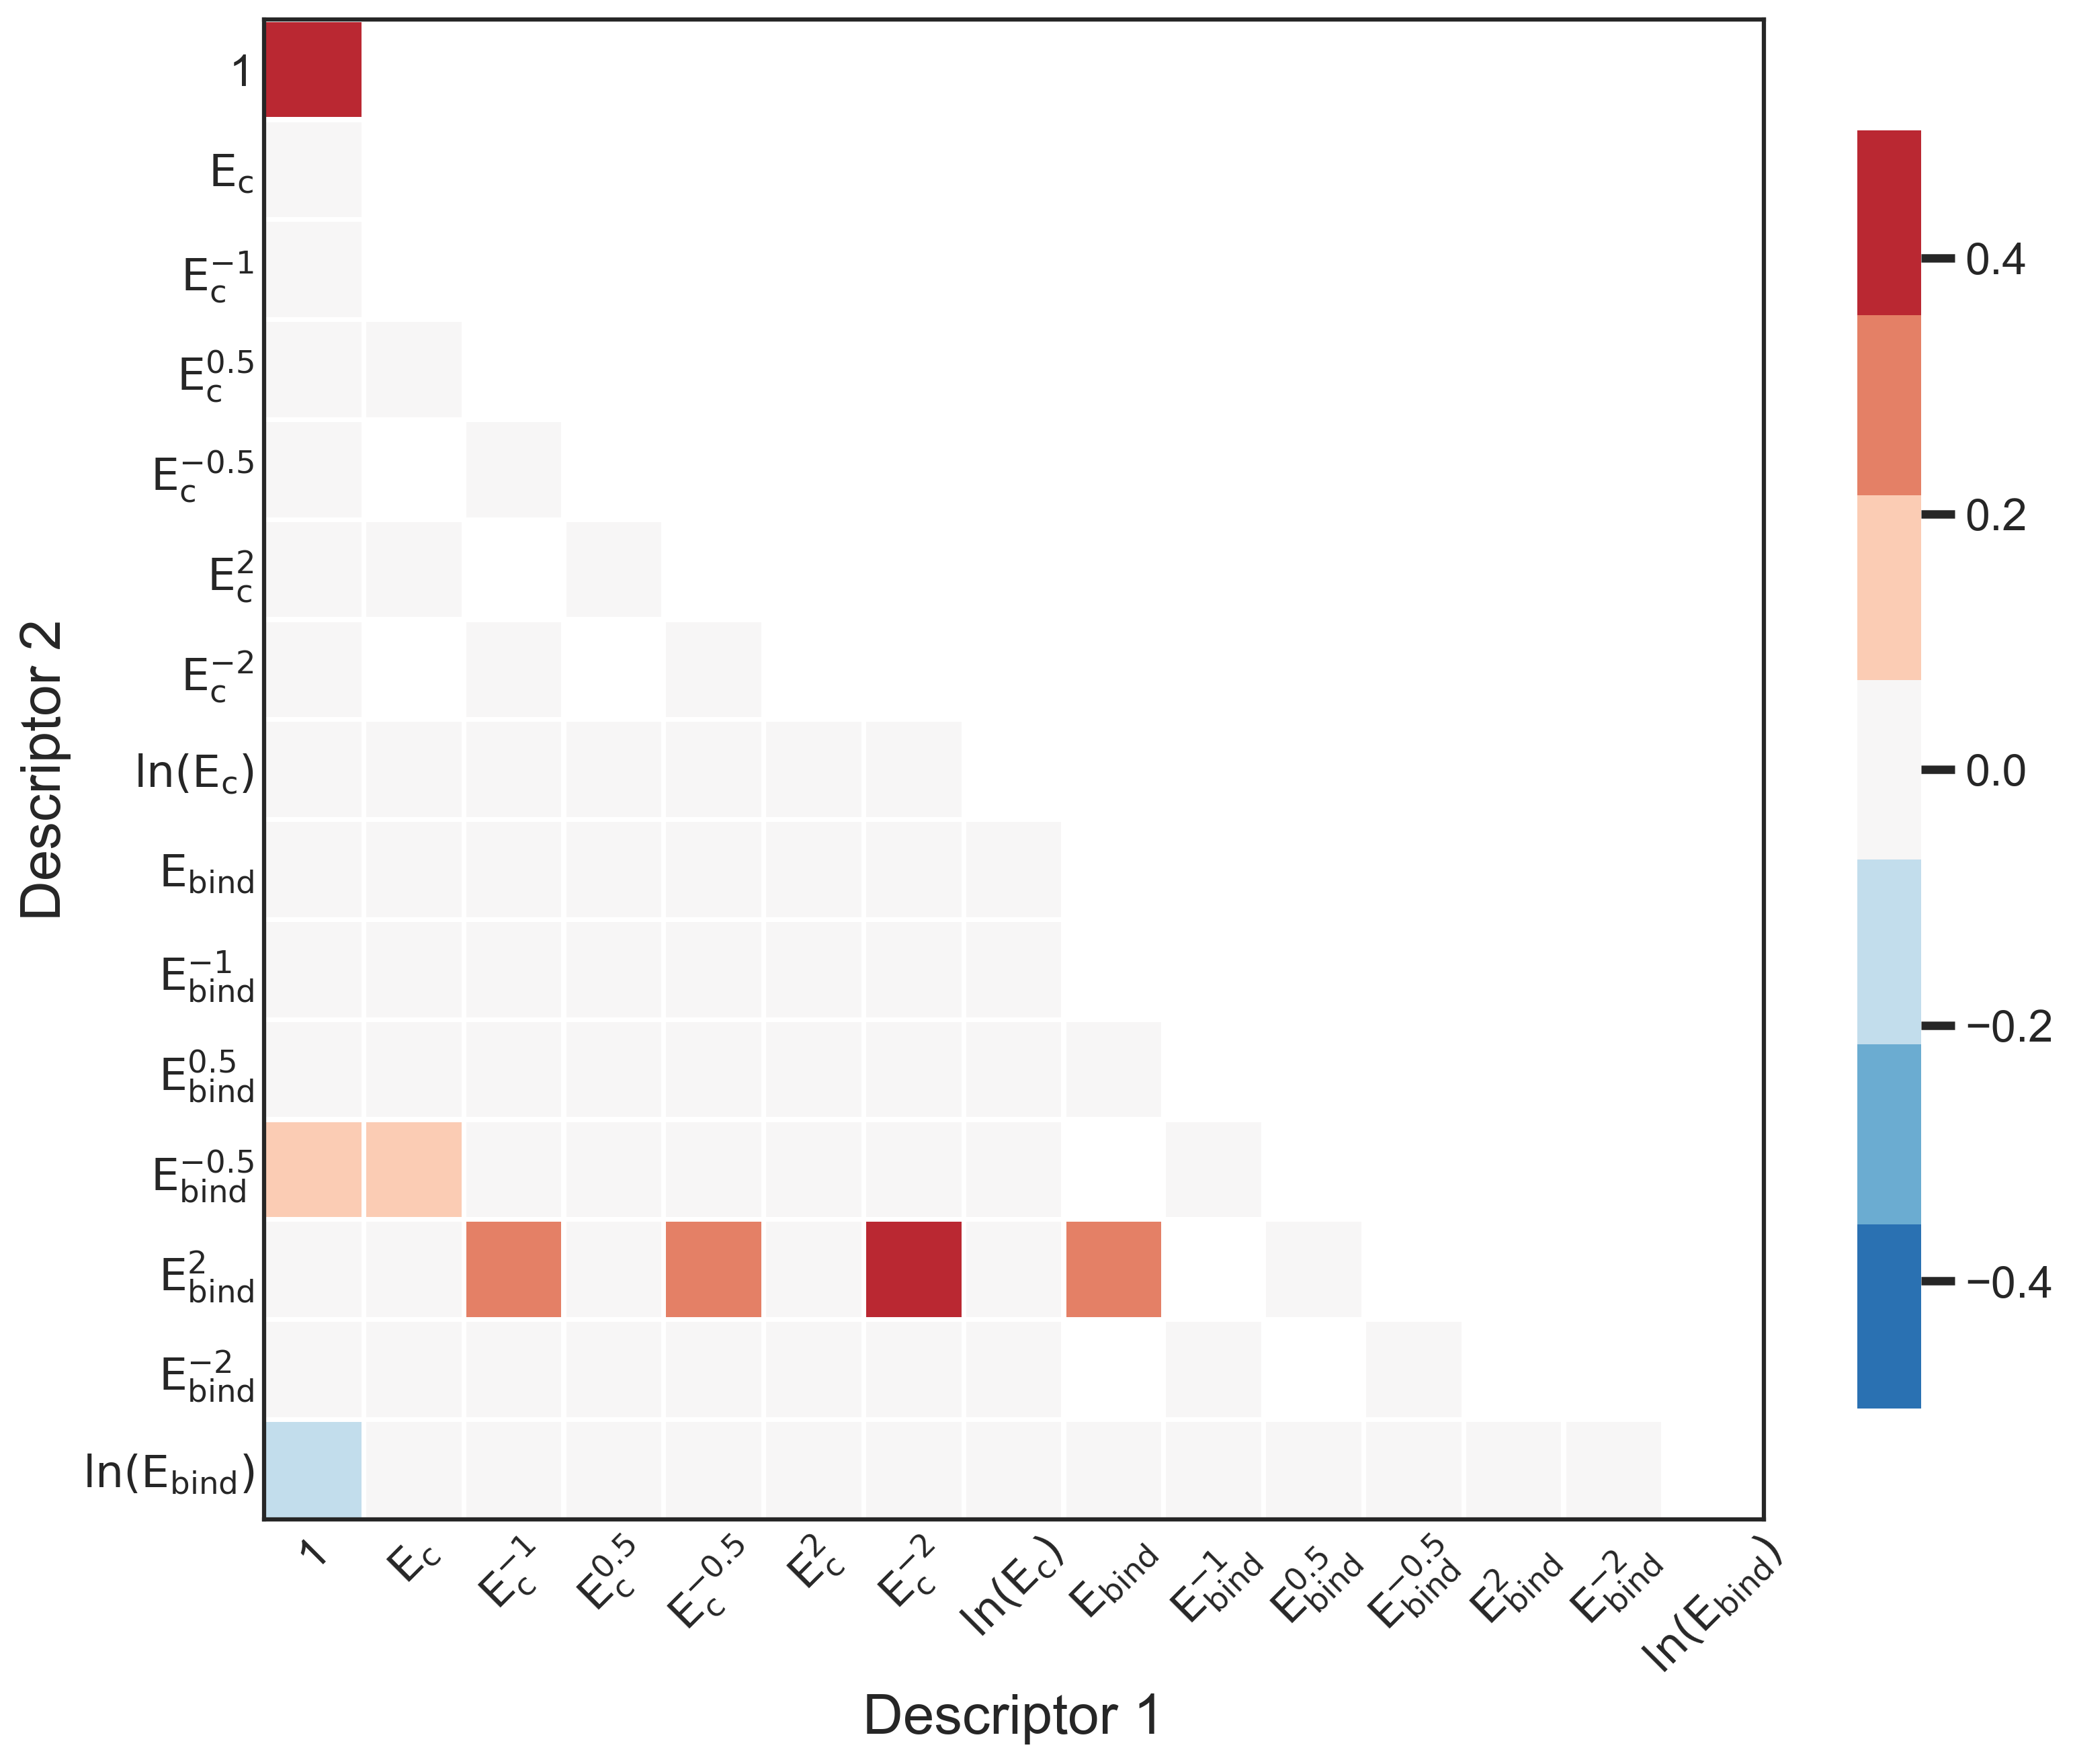

In [8]:
#%% elastic net results

model_name = 'enet'
output_dir = os.path.join(base_dir, model_name)
if not os.path.exists(output_dir): os.makedirs(output_dir)    

def l1_enet(ratio):
    
    '''
    input l1 ratio and return the model, non zero coefficients and cv scores
    training elastic net properly
    '''
    enet_cv  = ElasticNetCV(cv = rkf, l1_ratio=ratio,  max_iter = 1e7, tol = 0.001, fit_intercept=fit_int_flag, random_state= random_state)
    enet_cv.fit(X_train, y_train)
    
    # the optimal alpha
    enet_alpha = enet_cv.alpha_
    enet_coefs = enet_cv.coef_
    n_nonzero = len(np.where(abs(enet_coefs)>=1e-7)[0])
    # Access the errors 
    y_predict_test = enet_cv.predict(X_test)
    y_predict_train = enet_cv.predict(X_train)
    
    # error per cluster
    enet_RMSE_test = np.sqrt(mean_squared_error(y_test, y_predict_test))
    enet_RMSE_train = np.sqrt(mean_squared_error(y_train, y_predict_train))


    return enet_cv, enet_alpha, n_nonzero, enet_RMSE_test, enet_RMSE_train

'''
# Tune the l1 ratio by a grid search from 0 to 1
'''
# The vector of l1 ratio
l1s = [0.01, 0.05]
l1s = l1s + list(np.around(np.arange(0.1, 1.05, 0.05), decimals= 2))


enet = []
enet_alphas = []
enet_n  = []
enet_RMSE_test = []
enet_RMSE_train = []

print('Training Progress: \n')
for i, l1i in enumerate(l1s):
    # Report the training progress
    print('{:0.2f} % done'.format(100*(i+1)/len(l1s)))
    enet_cv, ai, n, RMSE_test, RMSE_train = l1_enet(l1i)
    
    enet.append(enet_cv)
    enet_alphas.append(ai)
    enet_n.append(n)
    
    enet_RMSE_test.append(RMSE_test)
    enet_RMSE_train.append(RMSE_train)

# Save elastic net results to csv
# expand the vector, put the result of ridge to the first
l1_ratio_v = np.array([0] + l1s)
enet_n_v  = np.array([X.shape[1]] + enet_n)
enet_RMSE_test_v = np.array([ridge_RMSE_test] + enet_RMSE_test)

enet_RMSE_test_v = [ridge_RMSE_test] + enet_RMSE_test
fdata = pd.DataFrame(np.transpose([l1_ratio_v, enet_n_v, enet_RMSE_test_v]), columns = ['l1 ratio', 'number of cluster', 'error per cluster (eV)'])
fdata.to_csv(os.path.join(output_dir, 'enet_data.csv'), index=False, index_label=False)

# Plot elastic net results
sns.set_style("ticks")
plt.figure(figsize=(8,6))
fig, ax1 = plt.subplots()
ax1.plot(l1_ratio_v, enet_RMSE_test_v, 'bo-')
ax1.set_xlabel('L1 Ratio')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('RMSE (ev)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(l1_ratio_v, enet_n_v, 'r--')
ax2.set_ylabel('# Descriptors', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
fig.savefig(os.path.join(output_dir, 'elastic_net.png'))


# enet_path to get alphas and coef_path
'''
# Use alpha grid prepare for enet_path when RMSE is mininal 
'''
enet_RMSE_path, enet_coef_path = rtools.cal_path(alphas_grid, ElasticNet, X_cv_train, y_cv_train, X_cv_test, y_cv_test, fit_int_flag)    
enet_min_index = np.argmin(enet_RMSE_test)
l1s_min = l1s[enet_min_index] 
enet_min = enet[enet_min_index]
enet_min_RMSE_test = np.amin(enet_RMSE_test)
rtools.plot_path(X, y, enet_alphas[enet_min_index], alphas_grid, enet_RMSE_path, enet_coef_path, enet[enet_min_index], model_name, output_dir)


# Select the significant cluster interactions 

# the optimal alpha from lassocv
enet_min_alpha = enet_min.alpha_
# Coefficients for each term
enet_min_coefs = enet_min.coef_
# The original intercepts 
enet_min_intercept = enet_min.intercept_
enet_min_r2_train = r2_score(y_train, enet_min.predict(X_train))


# The indices for non-zero coefficients/significant cluster interactions 
J_index = np.nonzero(enet_min_coefs)[0]
# The number of non-zero coefficients/significant cluster interactions  
n_nonzero = len(J_index)
# The values of non-zero coefficients/significant cluster interactions  
J_nonzero = enet_min_coefs[J_index] 

# collect nonzero freature names
x_feature_nonzero_combined = [x_features_poly_combined[pi] for pi in J_index]
x_feature_nonzero = [x_features_poly[pi] for pi in J_index]
# Plot the parity plot
enet_min_RMSE, enet_min_r2 = rtools.parity_plot(y, enet_min.predict(X), model_name, output_dir, enet_min_RMSE_test)


# Plot coefficients matrix
enet_min_coef_matrix = rtools.make_coef_matrix(x_feature_nonzero, J_nonzero, n_features, x_secondary_feature_names)
rtools.plot_tri_correlation_matrix(enet_min_coef_matrix, output_dir, x_plot_feature_names, model_name)
enet_min_prediction = enet_min.predict(X)

'''
Convert the coefficient to unnormalized form
'''
enet_min_coefs_unnormailized = np.zeros_like(enet_min_coefs)

enet_min_coefs_unnormailized[1:] = enet_min_coefs[1:]/sv
enet_min_coefs_unnormailized[0] = enet_min_coefs[0] - np.sum(mv/sv*enet_min_coefs[1:])

#### Ordinary least square (OLS) regression<a name="OLS"></a>

No handles with labels found to put in legend.


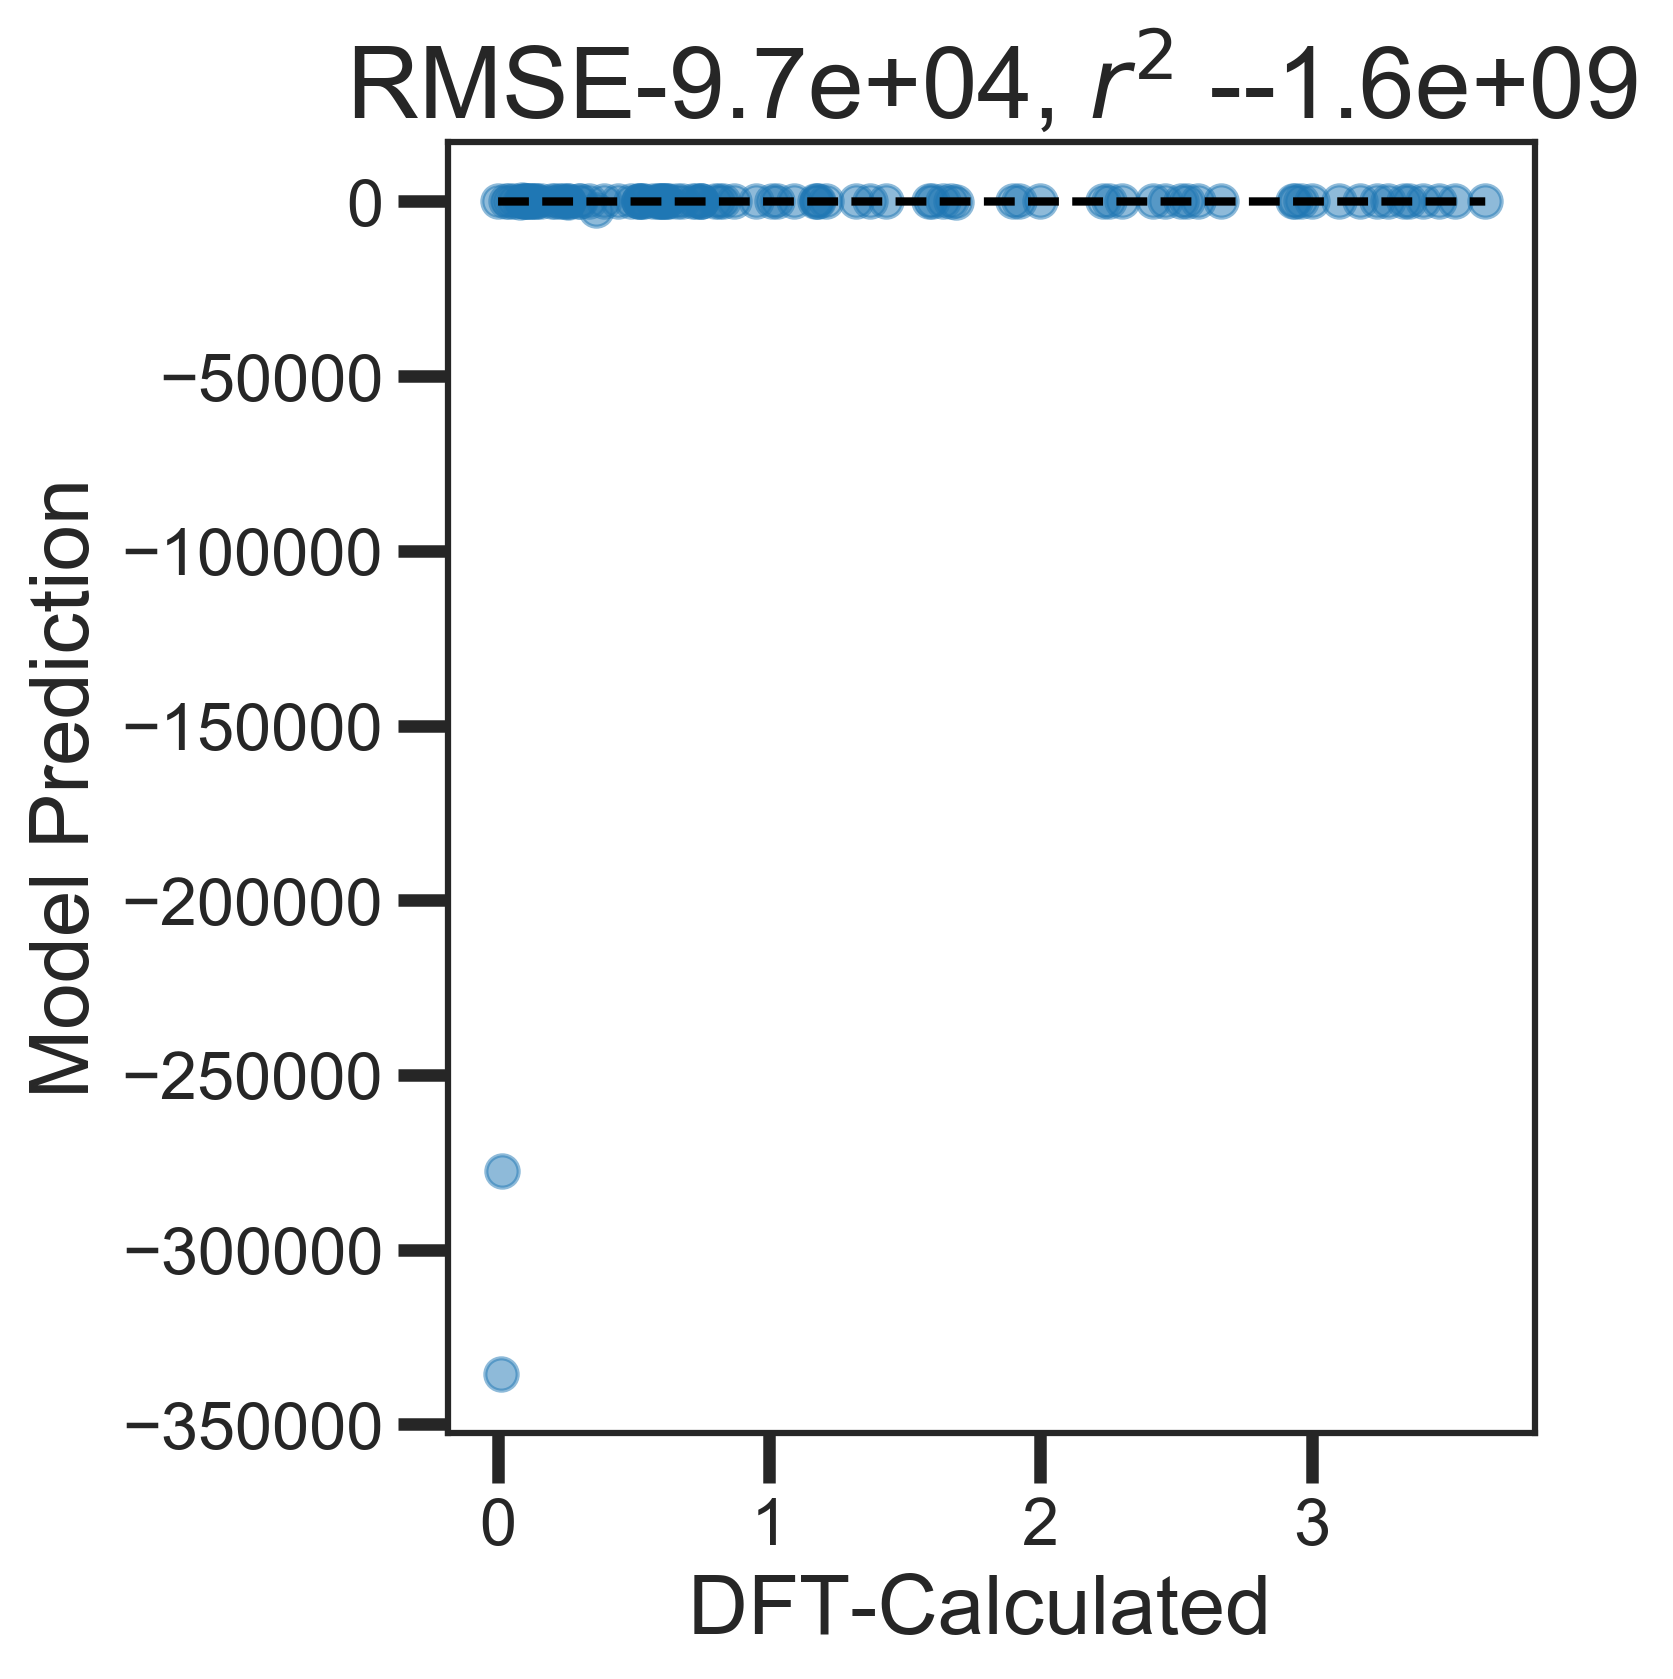

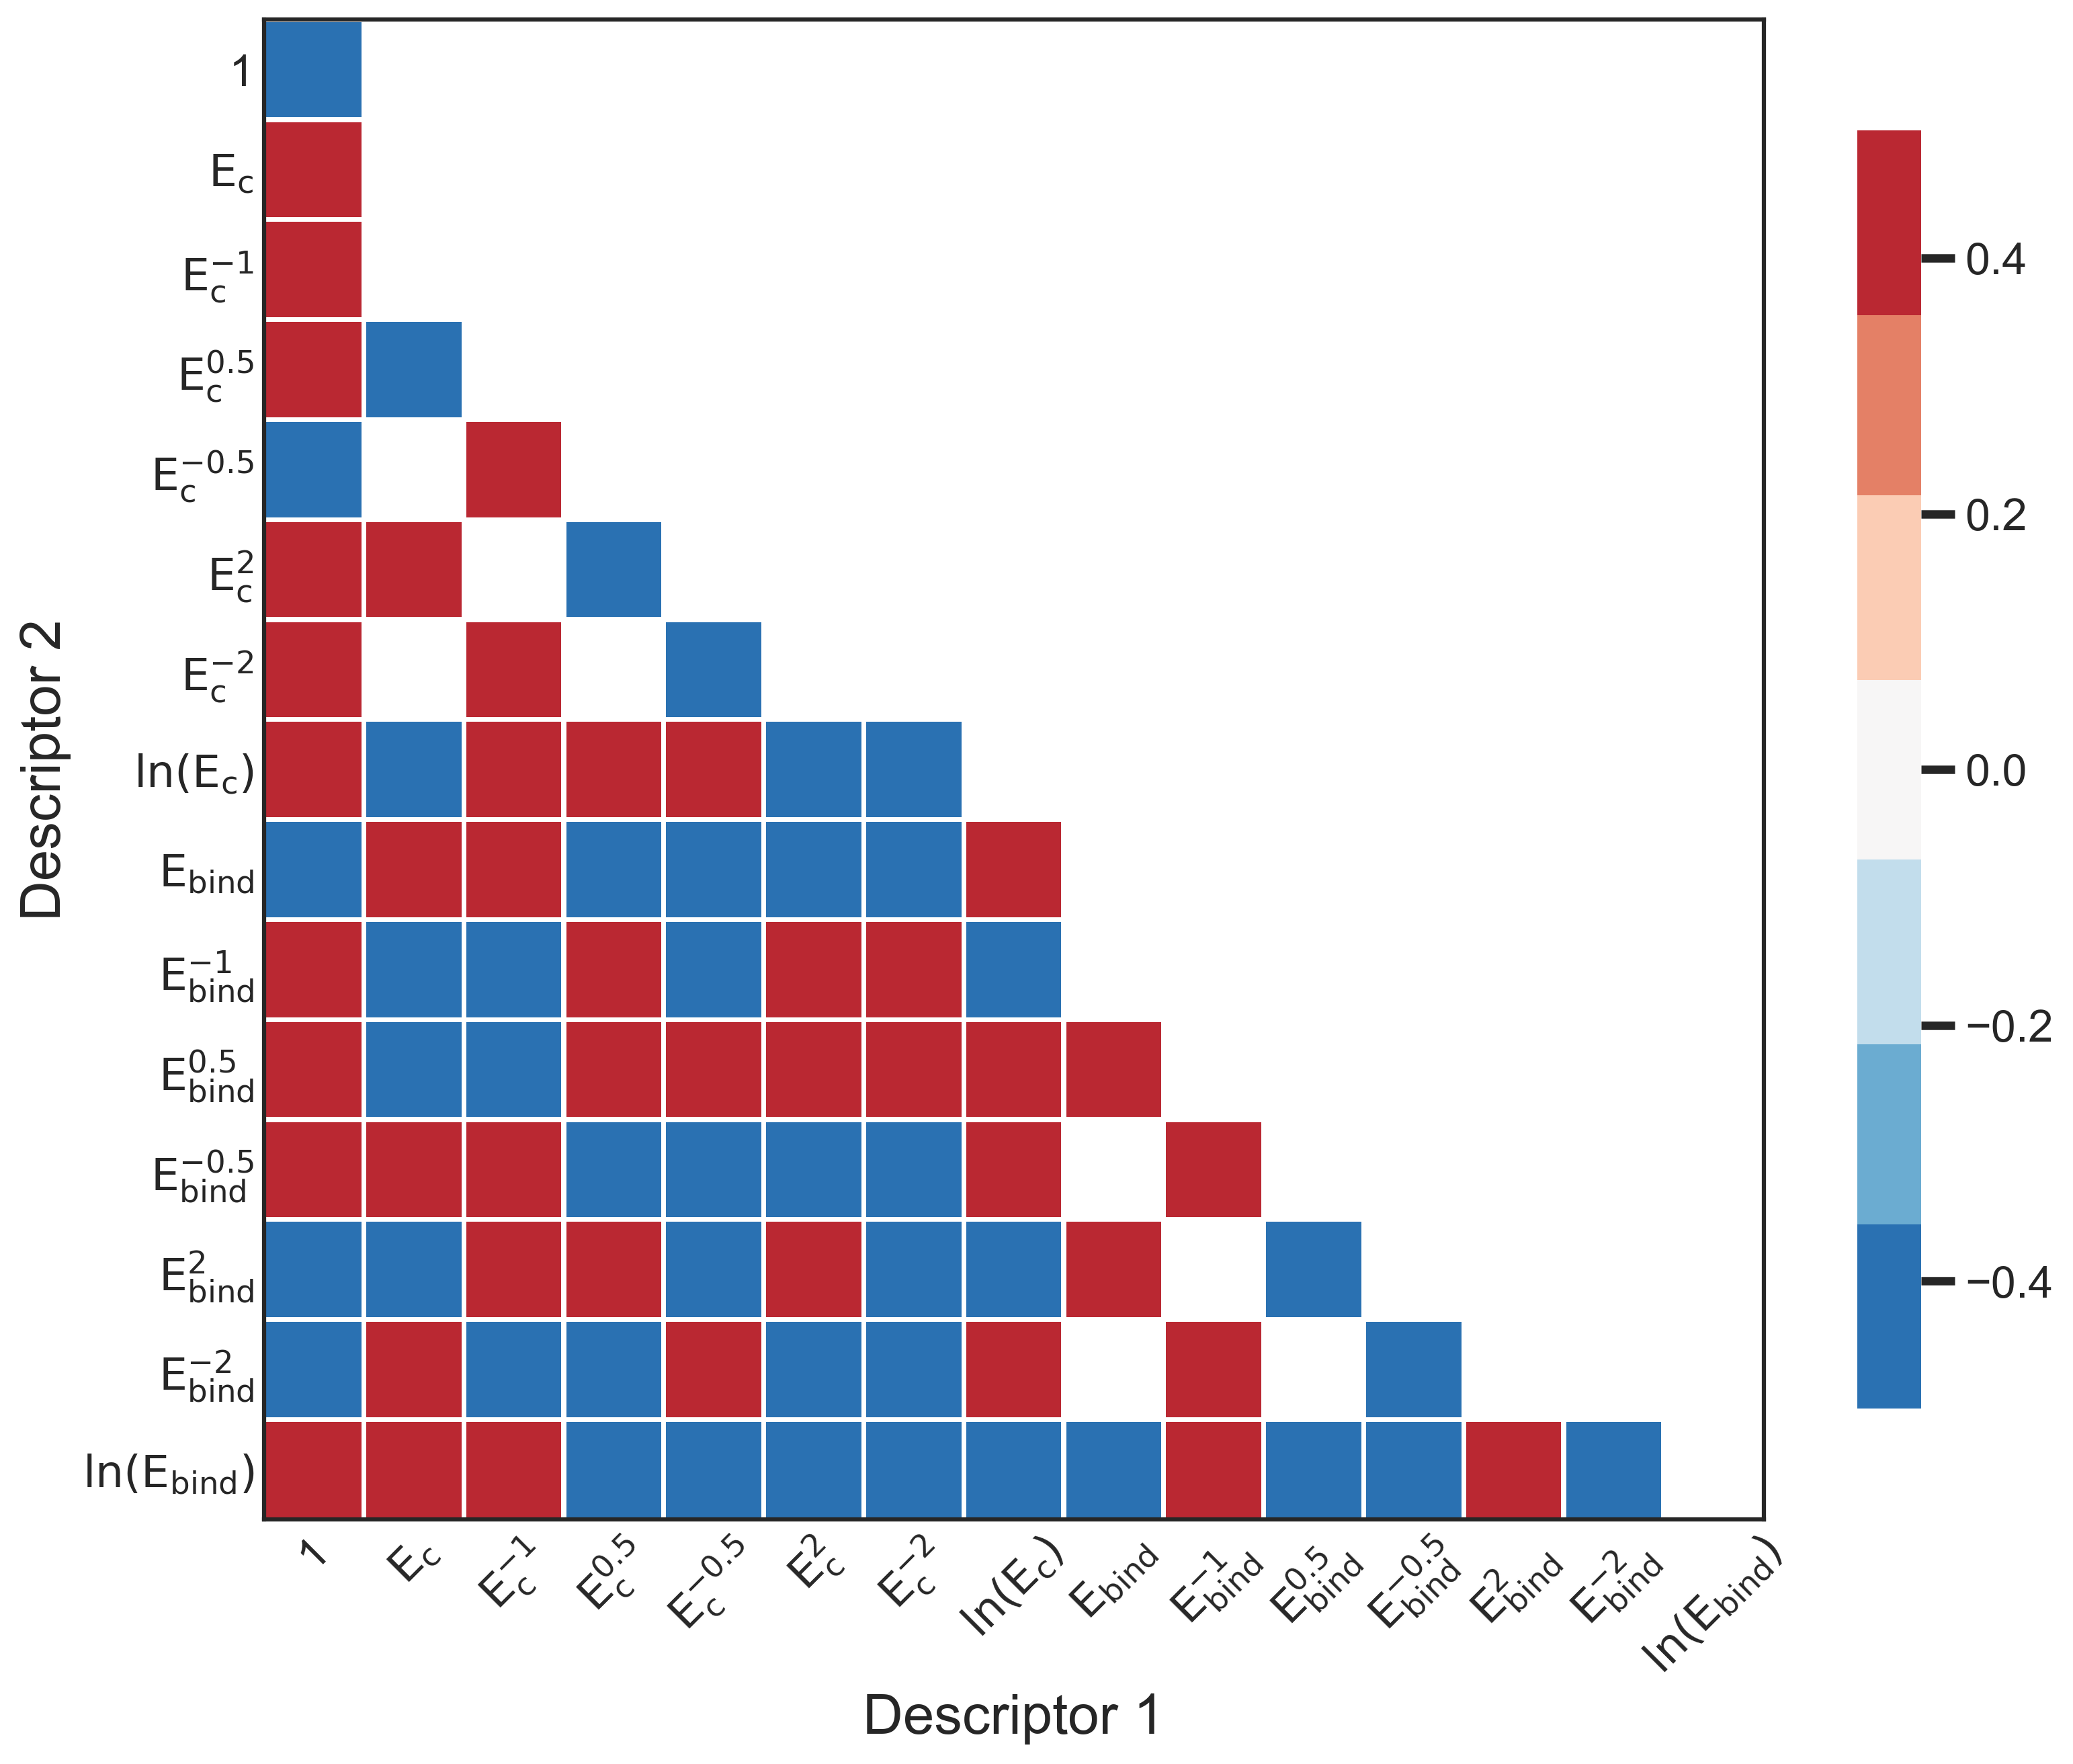

In [9]:
#%% Second order least square regression

model_name = 'OLS'
output_dir = os.path.join(base_dir, model_name)
if not os.path.exists(output_dir): os.makedirs(output_dir)    

OLS = linear_model.LinearRegression(fit_intercept=fit_int_flag)
OLS.fit(X_train,y_train) 
OLS_coefs = OLS.coef_

# Access the errors 
y_predict_test = OLS.predict(X_test)
y_predict_train = OLS.predict(X_train)
OLS_r2_train = r2_score(y_train, y_predict_train)

OLS_RMSE_test = np.sqrt(mean_squared_error(y_test, y_predict_test))
OLS_RMSE_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
# Plot the parity plot
OLS_RMSE, OLS_r2 = rtools.parity_plot(y, OLS.predict(X), model_name, output_dir, OLS_RMSE_test)


# Plot coefficients matrix
OLS_coef_matrix = rtools.make_coef_matrix(x_features_poly, OLS_coefs, n_features, x_secondary_feature_names)
rtools.plot_tri_correlation_matrix(OLS_coef_matrix, output_dir, x_plot_feature_names, model_name)
OLS_prediction = OLS.predict(X)

'''
Convert the coefficient to unnormalized form
'''
OLS_coefs_unnormailized = np.zeros_like(OLS_coefs)
OLS_coefs_unnormailized[1:] = OLS_coefs[1:]/sv
OLS_coefs_unnormailized[0] = OLS_coefs[0] - np.sum(mv/sv*OLS_coefs[1:])

#### Genetic Programming based on symbolic regression <a name="GP"></a>

The model was trained elsewhere



No handles with labels found to put in legend.


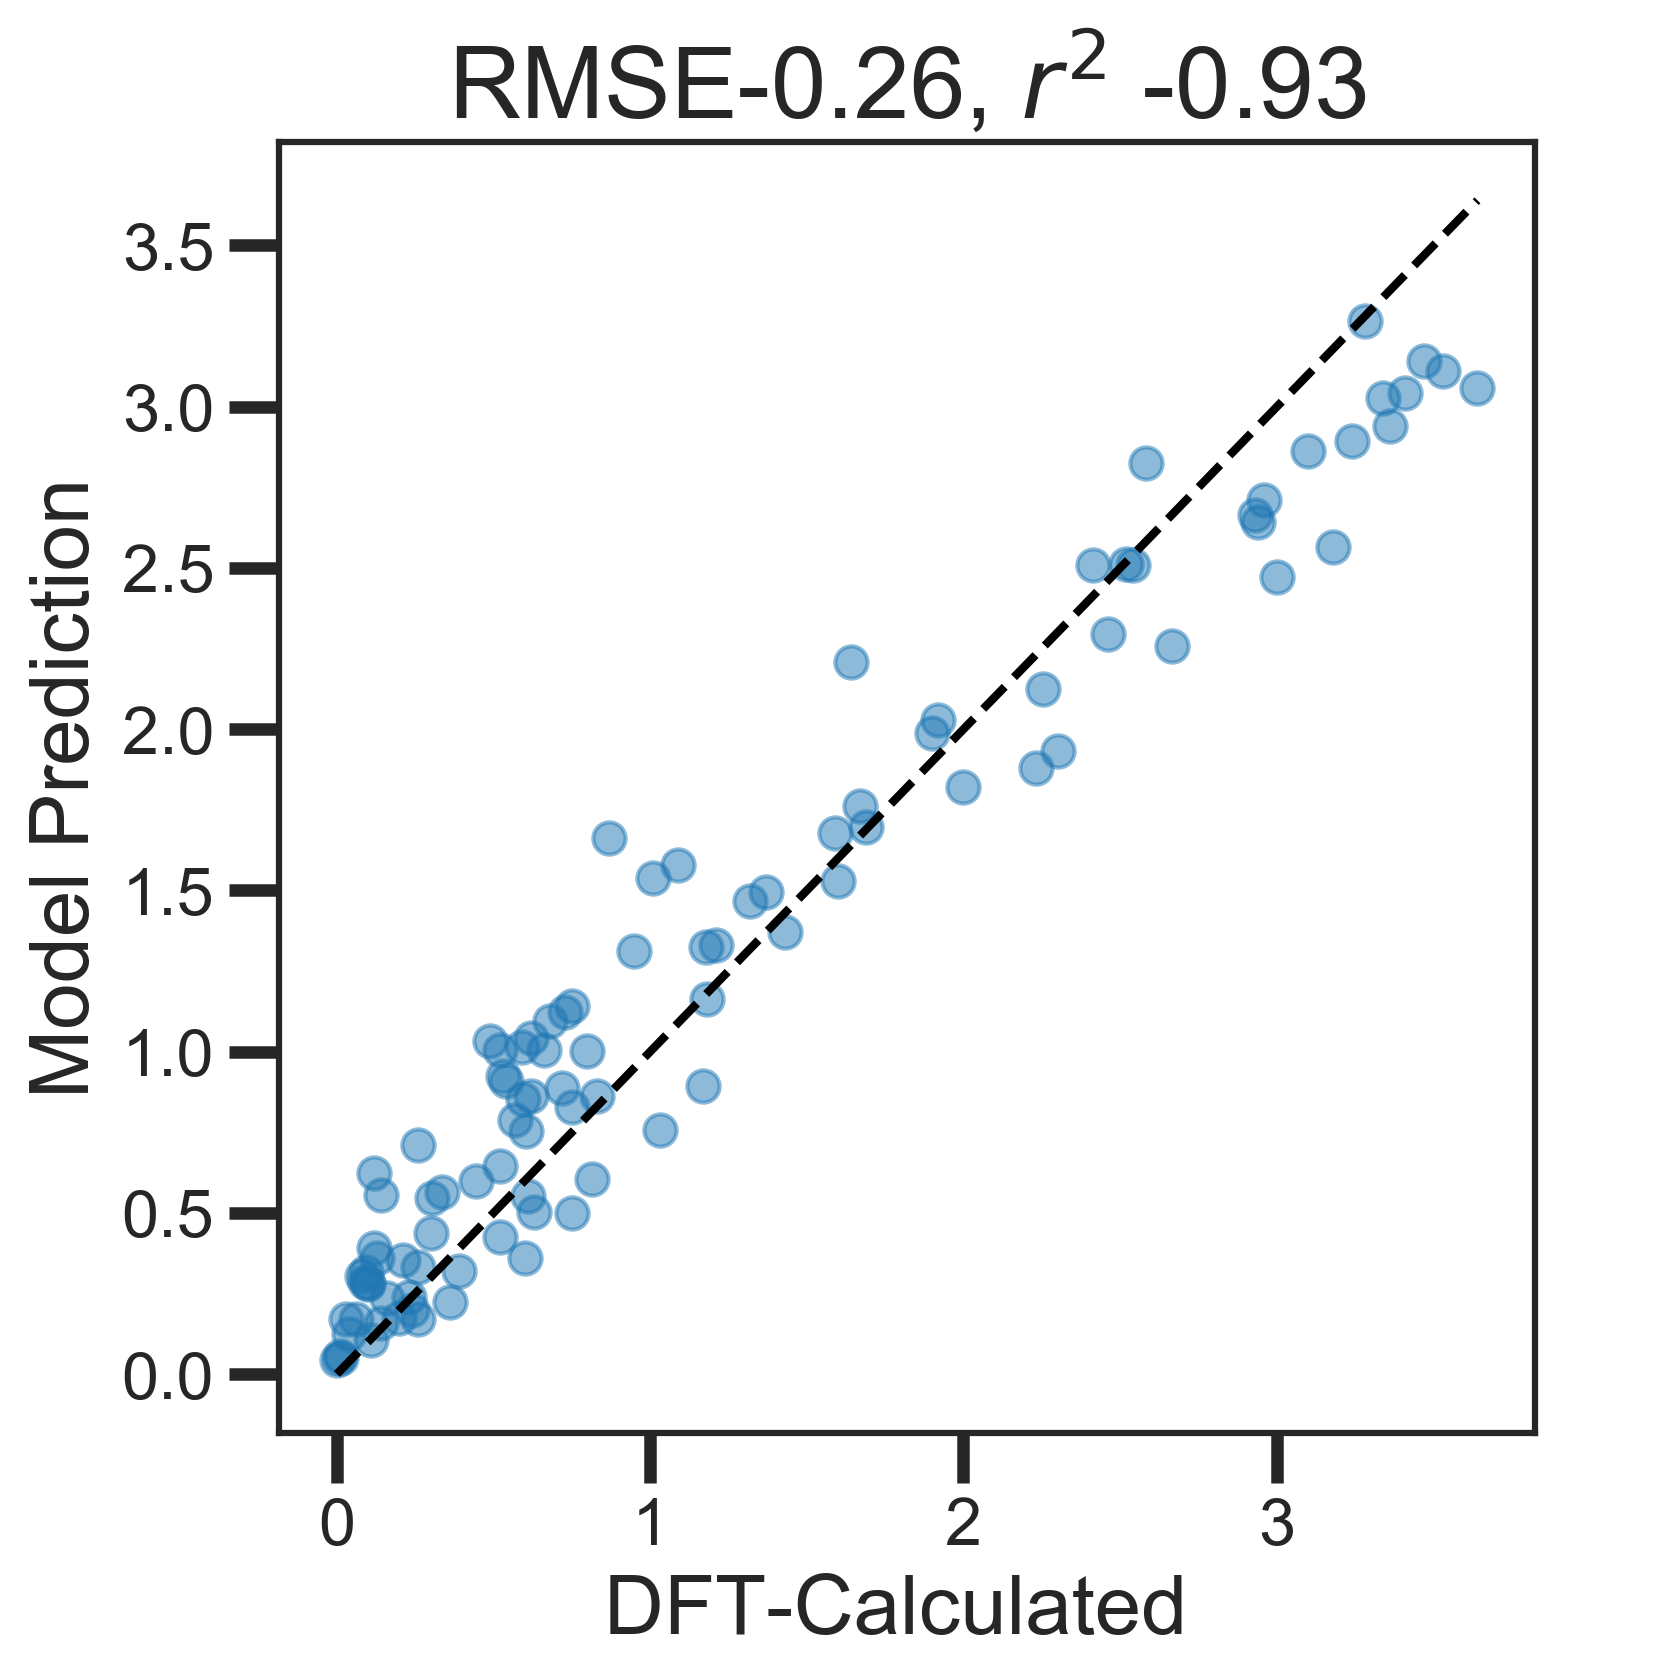

In [10]:
#%% Genetic programming model

model_name = 'GP'
output_dir = os.path.join(base_dir, model_name)
if not os.path.exists(output_dir): os.makedirs(output_dir)    

GP_coefs_unnormalized = 0.565

#GP_coefs_normailized = GP_coefs_unnormalized * sv[term_index]
GP_predict = lambda x: x * GP_coefs_unnormalized 

term_index = np.where(np.array(x_features_poly_combined) ==  'Ec_-1Ebind_2')[0][0]
X_GP_test = X_before_test[:,[term_index]]
X_GP_train = X_before_train[:,[term_index]]
X_GP = X_before_scaling[:, [term_index]]


# Access the errors 
y_predict_test = GP_predict(X_GP_test)
y_predict_train = GP_predict(X_GP_train)
GP_r2_train = r2_score(y_train, y_predict_train)


GP_RMSE_test = np.sqrt(mean_squared_error(y_test, y_predict_test))
GP_RMSE_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
# Plot the parity plot
GP_RMSE, GP_r2 =rtools.parity_plot(y, GP_predict(X_GP), model_name, output_dir, GP_RMSE_test)
GP_prediction =  GP_predict(X_GP)

#### Univerisal Diffusion Scaling relation (DSL) <a name="DSL"></a>


No handles with labels found to put in legend.


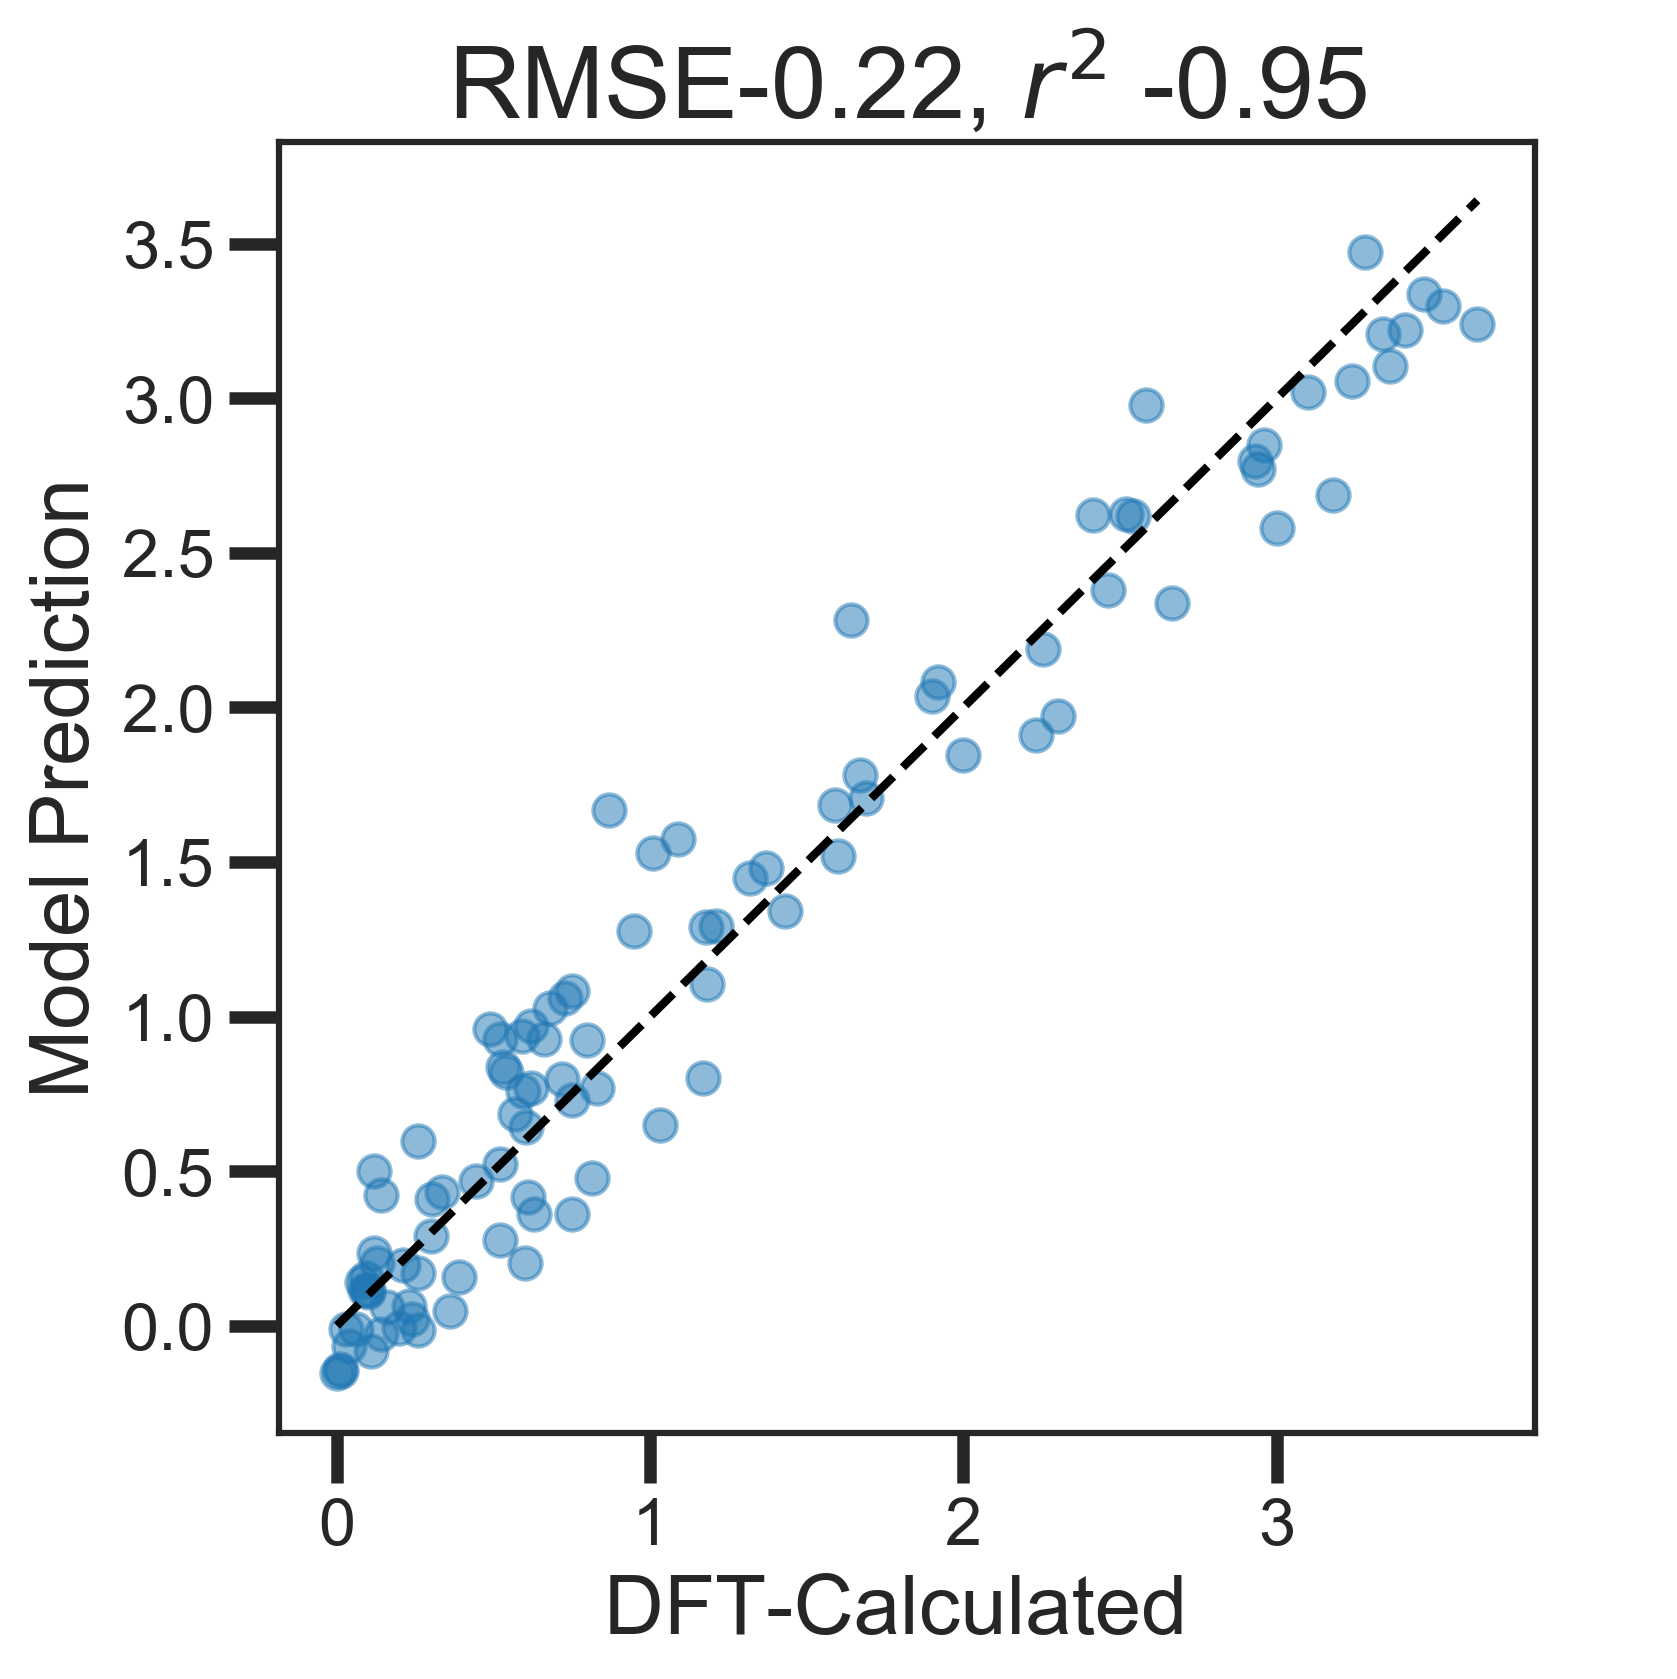

In [11]:
#%% Univerisal scaling model, fit Ebind^2/Ec vs Ea

model_name = 'DSL'
output_dir = os.path.join(base_dir, model_name)
if not os.path.exists(output_dir): os.makedirs(output_dir)
    
term_index = np.where(np.array(x_features_poly_combined) ==  'Ec_-1Ebind_2')[0][0]
DSL = linear_model.LinearRegression(fit_intercept=fit_int_flag)
X_DSL_test = X_test[:,[0,term_index]]
X_DSL_train = X_train[:,[0,term_index]]
X_DSL = X[:,[0,term_index]]
DSL.fit(X_DSL_train,y_train) 
DSL_coefs =  np.zeros_like(ridge_coefs)
DSL_coefs[[0,term_index]] = DSL.coef_

# Access the errors 
y_predict_test = DSL.predict(X_DSL_test)
y_predict_train = DSL.predict(X_DSL_train)
DSL_r2_train = r2_score(y_train, y_predict_train)


DSL_RMSE_test = np.sqrt(mean_squared_error(y_test, y_predict_test))
DSL_RMSE_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
# Plot the parity plot
DSL_RMSE, DSL_r2 =rtools.parity_plot(y, DSL.predict(X_DSL), model_name, output_dir, DSL_RMSE_test)

# the unnormalized coefficients
DSL_coefs_unnormailized = np.zeros_like(DSL_coefs)
DSL_coefs_unnormailized[1:] = DSL_coefs[1:]/sv
DSL_coefs_unnormailized[0] = DSL_coefs[0] - np.sum(mv/sv*DSL_coefs[1:])
u0= DSL_coefs_unnormailized[0] #intercept
u1 = DSL_coefs_unnormailized[term_index] # the coefficient
DSL_prediction = DSL.predict(X_DSL)


### Step 6 - Compare models 


#### Compare the best elastic net model (including lasso and ridge) with DSL <a name="models"></a>


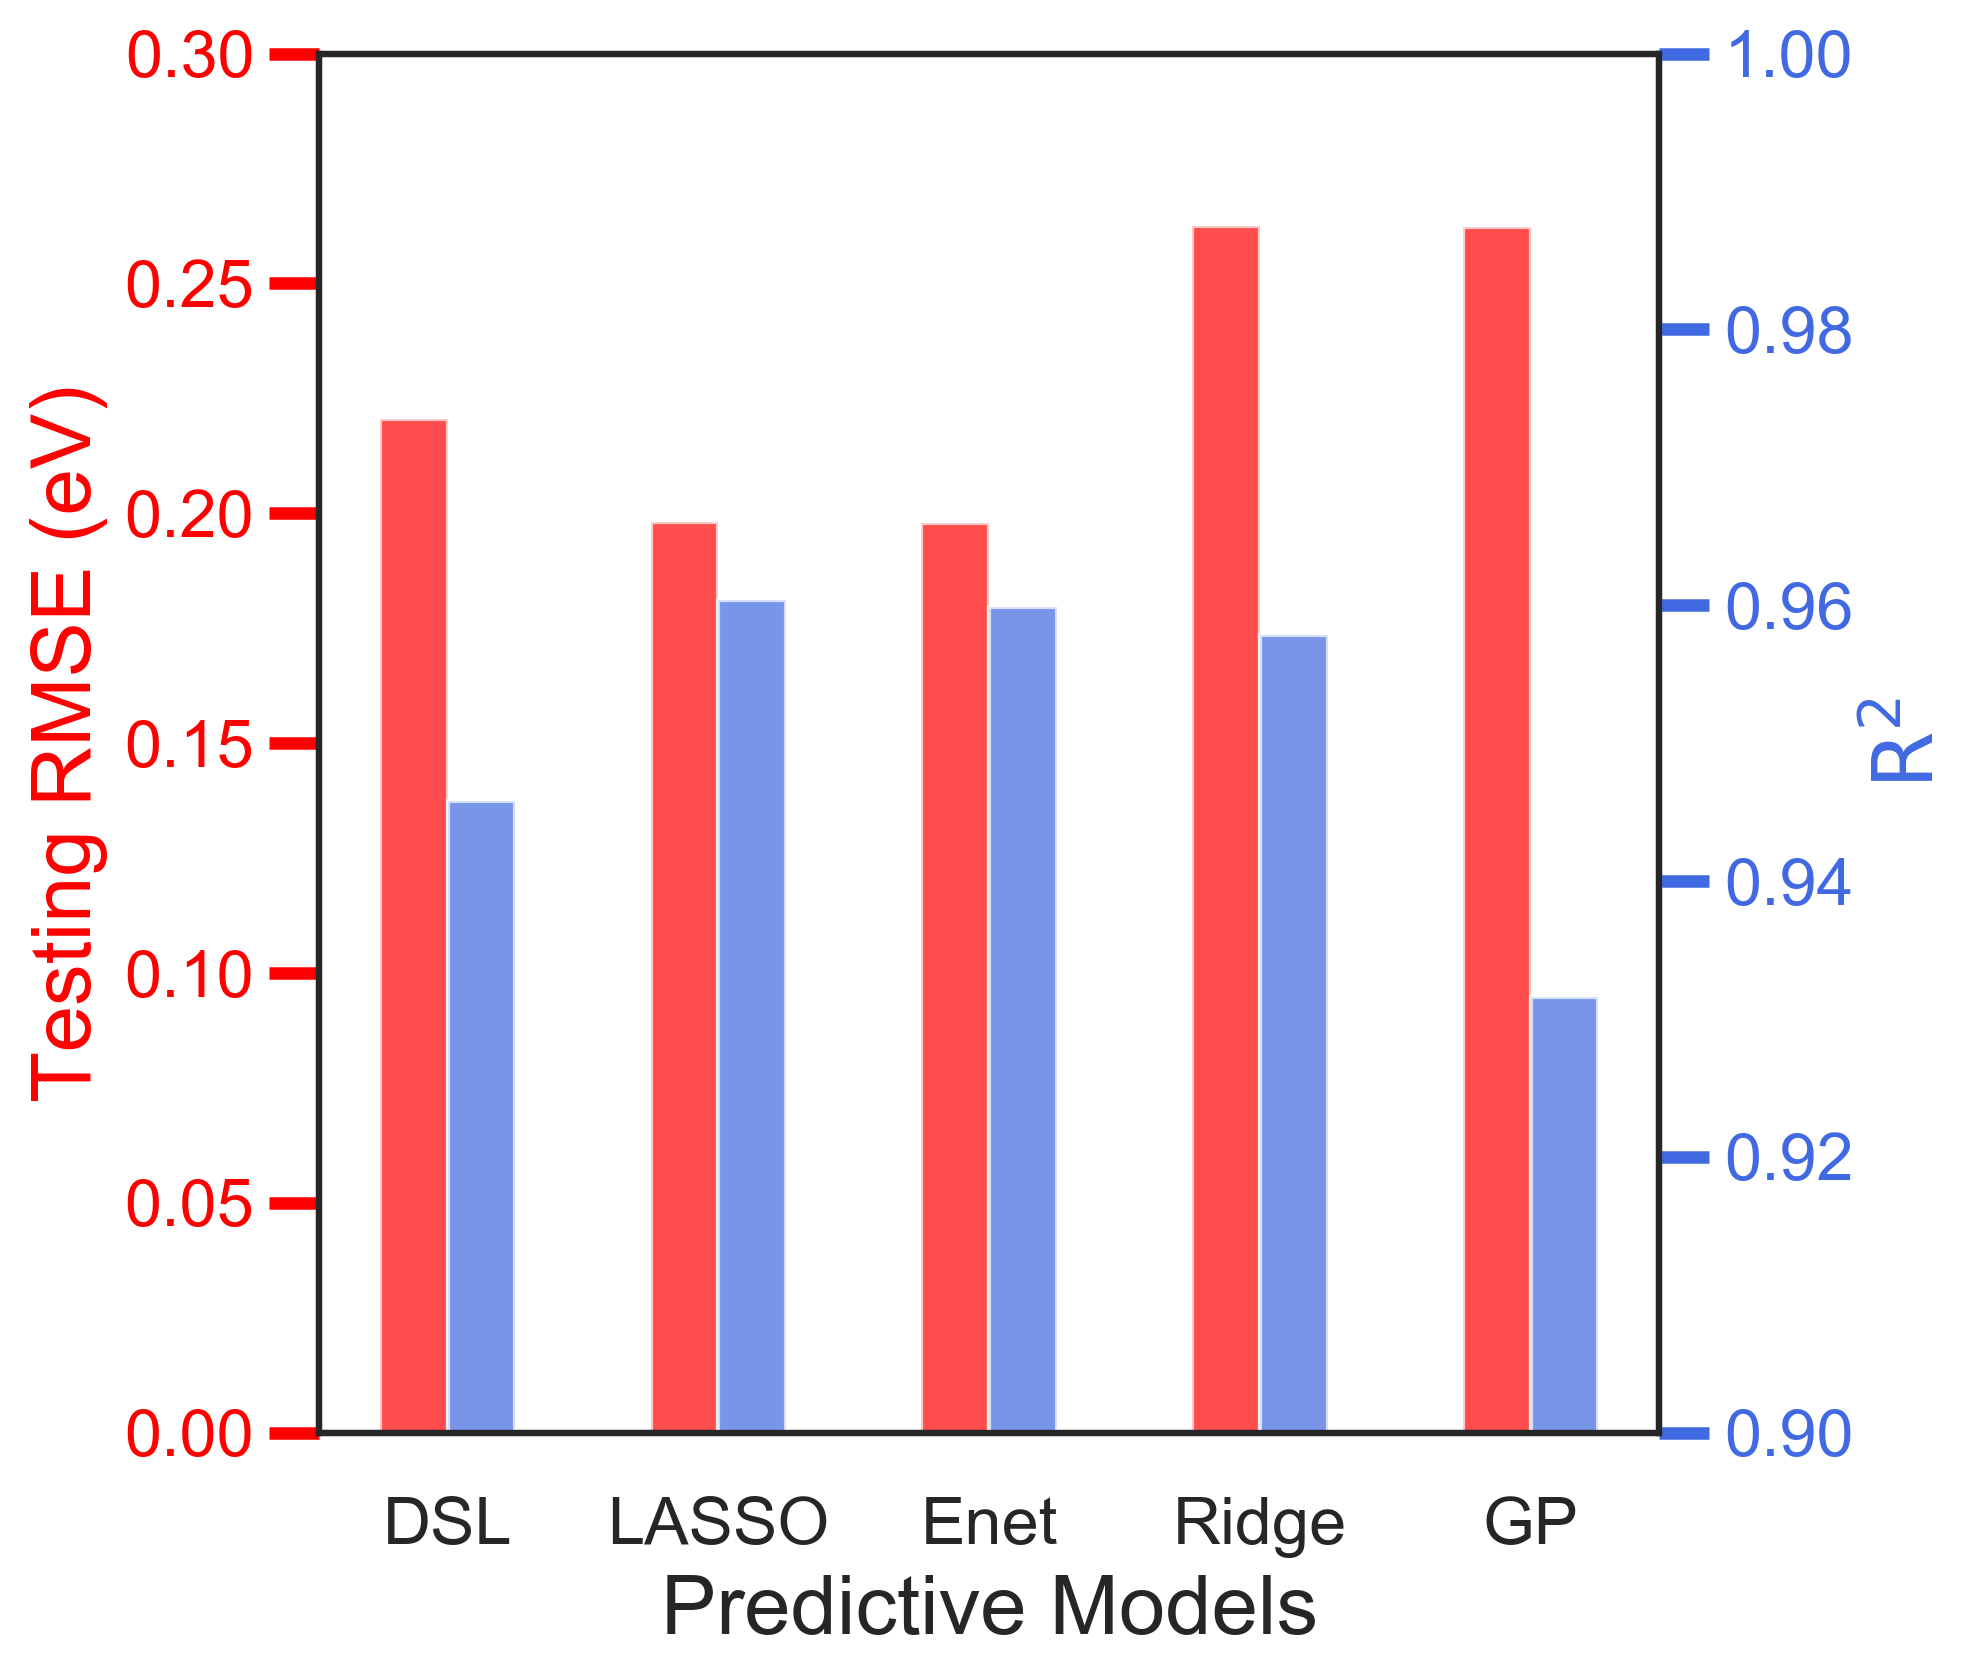

In [12]:
#%% Compare different regression method

regression_method = [ 'DSL',  'LASSO', 'Enet', 'Ridge', 'GP']

n_method = len(regression_method)

means_test = np.array([ DSL_RMSE_test,  lasso_RMSE_test, enet_min_RMSE_test, ridge_RMSE_test,  GP_RMSE_test])
r2s = np.array([ DSL_r2,  lasso_r2, enet_min_r2, ridge_r2,  GP_r2])

x_pos = np.arange(len(regression_method))
base_line = 0

opacity = 0.7
bar_width = 0.25
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(7,6))
ax2 = ax1.twinx()
rects2 = ax1.bar(x_pos, means_test - base_line, bar_width, # testing RMSE
                alpha = opacity, color='r',
                label='Test')
rects3 = ax2.bar(x_pos+bar_width, r2s - base_line, bar_width,  #R2
                alpha = opacity, color='royalblue',
                label='r2')

ax1.set_xticks(x_pos+bar_width/2)
ax1.set_xticklabels(regression_method, rotation=0)
ax1.set_xlabel('Predictive Models')

ax1.set_ylabel('Testing RMSE (eV)', color = 'r')
ax1.set_ylim([0, 0.3])
ax1.tick_params('y', colors='r')

ax2.set_ylabel(r'$\rm R^2$',color = 'royalblue')
ax2.set_ylim([0.9, 1])
ax2.tick_params('y', colors='royalblue')
plt.tight_layout()
fig.savefig(os.path.join(output_dir, model_name + '_performance.png'))

#### DSL performance across support <a name="supports"></a>


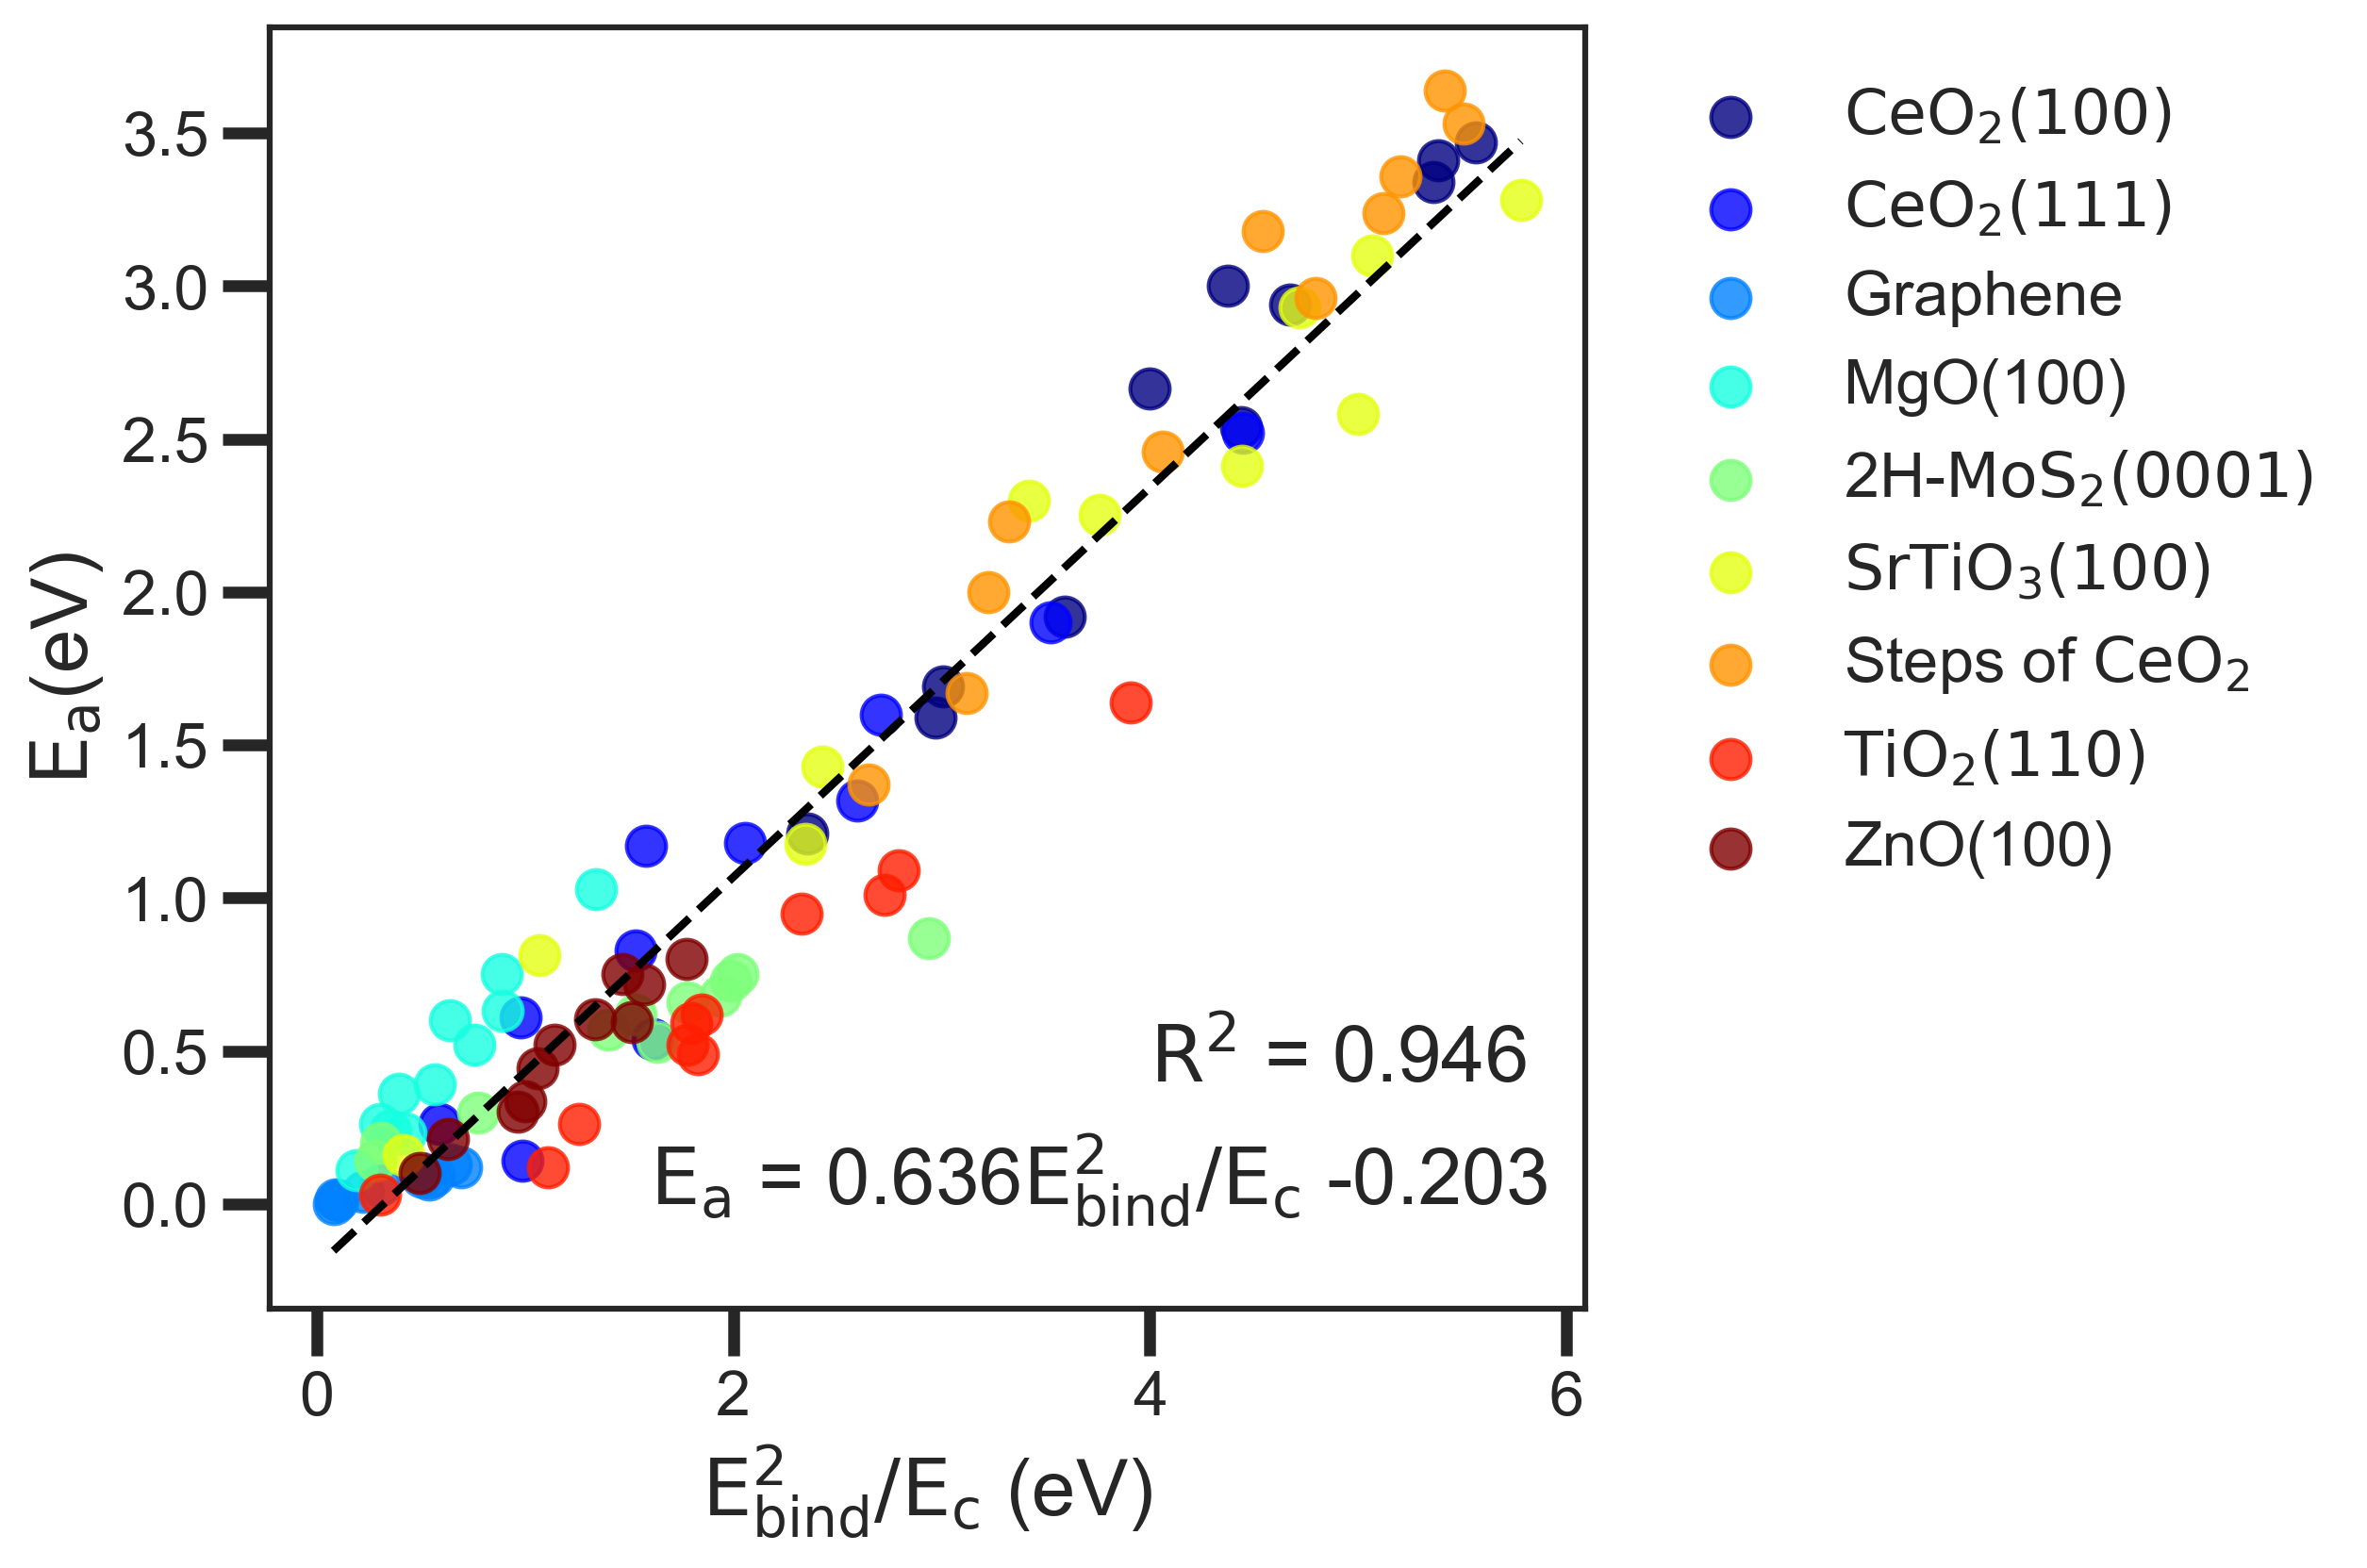

In [13]:
#%% DSL performance plot based on metal and support
 
metal_types = np.unique(metal)

support_types = np.unique(support)

'''
Based on support
'''
category = support.copy()
types = support_types.copy()

legend_labels = [r'$\rm CeO_{2}(100)$', r'$\rm CeO_{2}(111)$', 'Graphene', 'MgO(100)', '2H-'+r'$\rm MoS_{2}(0001)$', r'$\rm SrTiO_{3}(100)$',
         'Steps of ' + r'$\rm CeO_{2}$', r'$\rm TiO_{2}(110)$', 'ZnO(100)']
term_index = np.where(np.array(x_features_poly_combined) ==  'Ec_-1Ebind_2')[0][0]
x_plot =  X_before_scaling[:,term_index]
y_plot = y.copy()
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 6))
color_set = cm.jet(np.linspace(0,1,len(types)))
for type_i, ci, label_i in zip(types, color_set, legend_labels):
    indices = np.where(np.array(category) == type_i)[0]
    ax.scatter(x_plot[indices],
                y_plot[indices],
                label=label_i,
                facecolor = ci, 
                alpha = 0.8,
                s  = 100)
ax.plot([x_plot.min(), x_plot.max()], [DSL.predict(X_DSL).min(), DSL.predict(X_DSL).max()], 'k--',  lw=2)
ax.set_xlabel(r'$\rm E_{bind}^2/E_c$ ' + '(eV)')
ax.set_ylabel(r'$\rm E_a$' +'(eV)')

plt.text(1.6,0, r'$\rm E_a$ = ' + str(np.around(u1, decimals = 3)) + r'$\rm E_{bind}^2/E_c$ ' + str(np.around(u0, decimals = 3)))
plt.text(4,0.4, r'$\rm R^2$ = ' + str(np.around(DSL_r2, decimals = 3)) )

plt.legend(bbox_to_anchor = (1.02, 1),loc= 'upper left', frameon=False)

fig.savefig(os.path.join(output_dir, model_name + '_parity_support.png'))


#### DSL performance across metal <a name="metals"></a>


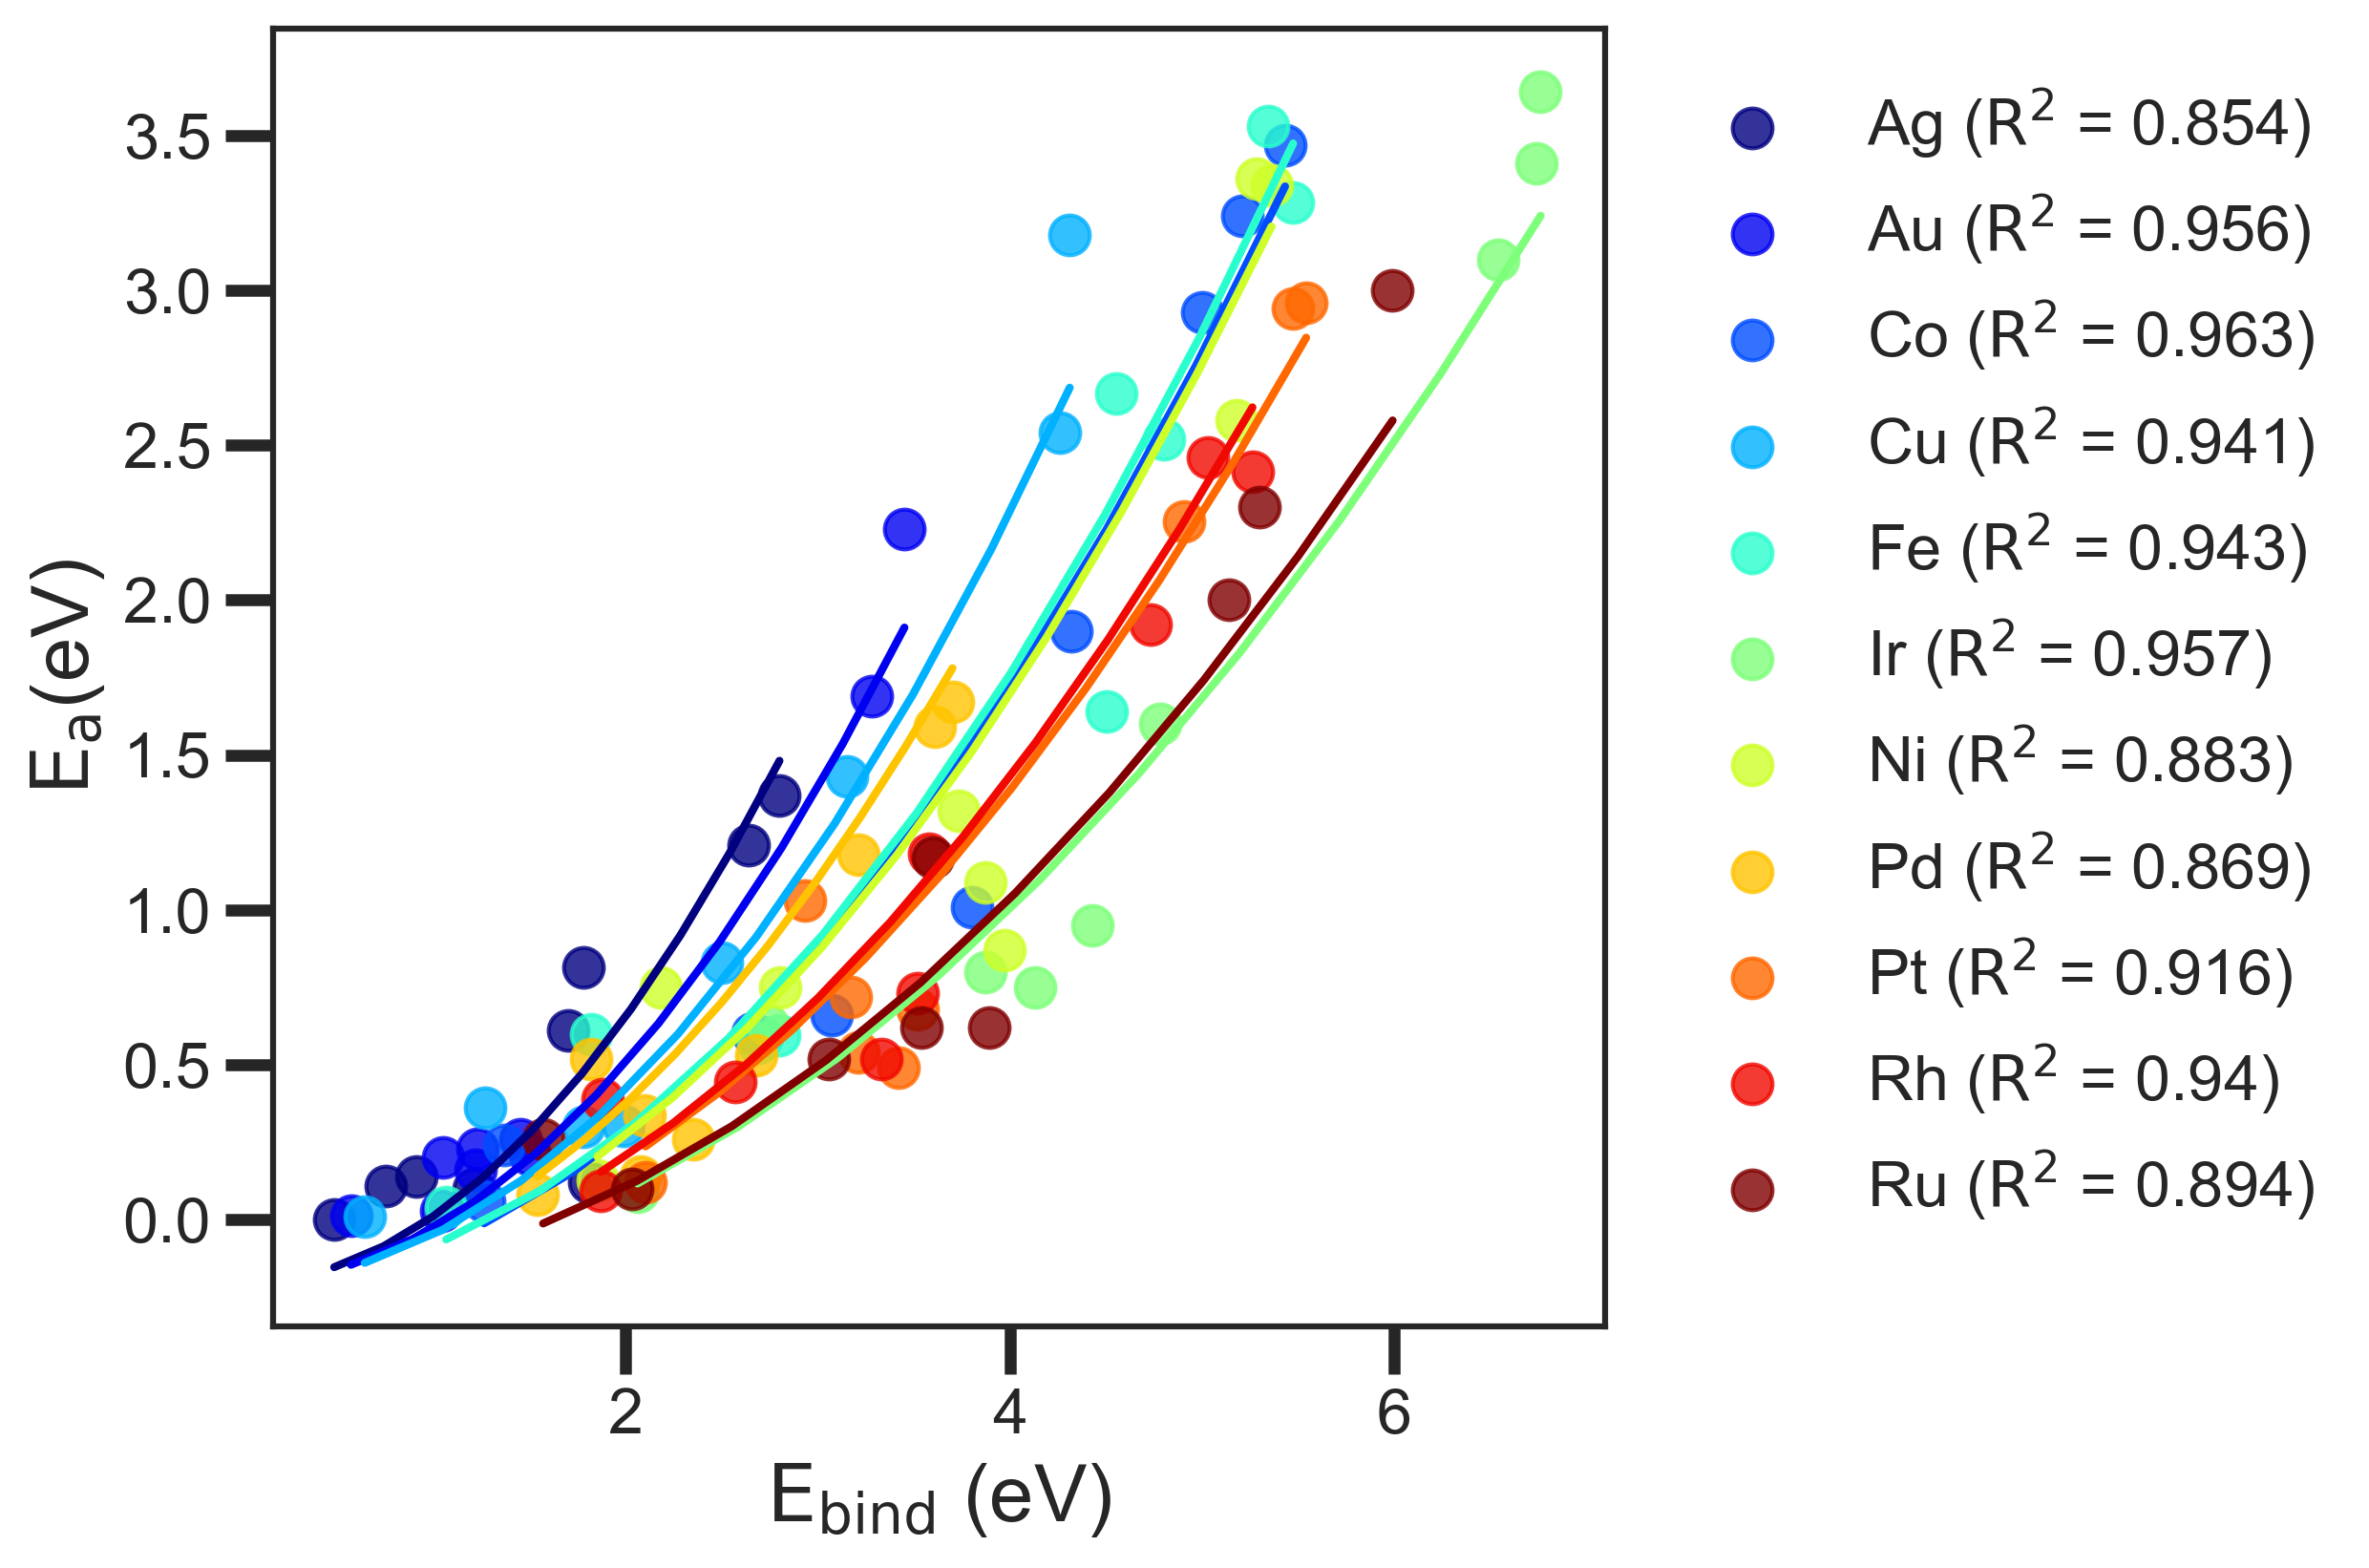

In [14]:
#%% Based on metal

category = metal.copy()
types = metal_types.copy()
term_index_bind = np.where(np.array(x_features_poly_combined) == 'Ebind_1')[0][0]
term_index_c = np.where(np.array(x_features_poly_combined) == 'Ec_1')[0][0]

x_plot_bind =  X_before_scaling[:,term_index_bind]
x_plot_c =  X_before_scaling[:,term_index_c]
y_plot = y.copy()
mesh = 10

DSL_function = lambda x, y: x**2/y * u1 + u0 

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 6))
color_set = cm.jet(np.linspace(0,1,len(types)))


for type_i, ci in zip(types, color_set):
    indices = np.where(np.array(category) == type_i)[0]
    ax.scatter(x_plot_bind[indices],
                y_plot[indices],
                label=type_i+ ' ('+ r'$\rm R^2$ = ' + str(np.around(r2_score(DSL.predict(X_DSL)[indices], y_plot[indices]), decimals = 3)) + ')',
                facecolor = ci, 
                alpha = 0.8,
                s  = 100)
    x_line = np.linspace(x_plot_bind[indices].min(),  x_plot_bind[indices].max(), mesh)
    y_line = DSL_function(x_line, x_plot_c[indices][0])
    ax.plot(x_line, y_line, linestyle = '-', color = ci,  lw=2)
    
    
ax.set_xlabel(r'$\rm E_{bind}$ ' + '(eV)')
ax.set_ylabel(r'$\rm E_a$' +'(eV)')


plt.legend(bbox_to_anchor = (1.02, 1),loc= 'upper left', frameon=False)

fig.savefig(os.path.join(output_dir, model_name + '_parity_metal.png'))